In [ ]:
!pip install mne
!pip install mne-icalabel
!pip install keras-tuner


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 24.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.6/21.6 MB 95.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.4 MB/s eta 0:00:00


In [ ]:
# Import necessary libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mne
from mne.preprocessing import ICA
from mne_icalabel import label_components
import re
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from keras_tuner.tuners import RandomSearch
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

# Constants
FS = 128  # Sampling frequency
METADATA_COLUMNS =  [
    'EEG.Counter', 'EEG.Interpolated', 'EEG.RawCq', 'EEG.Battery',
    'EEG.BatteryPercent', 'EEG.MarkerHardware'
]

print("Libraries imported and constants initialized.")

Libraries imported and constants initialized.


In [ ]:
import os
import re
import pandas as pd

# Function to load and preprocess each participant's EEG CSV individually
def load_dataset_file_by_file(root_folder):
    dataset = []  # List of tuples: (dataframe, label, participant_id)

    for letter_folder in sorted(os.listdir(root_folder)):  # Optional: sort for consistency
        letter_path = os.path.join(root_folder, letter_folder)
        if not os.path.isdir(letter_path):
            print(f"Skipping {letter_path} (not a directory)")
            continue

        print(f"Processing letter folder: {letter_folder}")
        label = letter_folder  # Use folder name as label

        for file in os.listdir(letter_path):
            file_path = os.path.join(letter_path, file)
            if not os.path.isfile(file_path) or not file.endswith('.csv'):
                print(f"  Skipping {file} (not a .csv file)")
                continue

            print(f"  Reading participant file: {file}")
            try:
                df = pd.read_csv(file_path, skiprows=1)

                # Extract participant name using regex
                match = re.match(r'(par\.\d+)', file)
                participant_name = match.group(0) if match else "unknown"

                # Append as a tuple: (dataframe, label, participant_id)
                dataset.append((df, label, participant_name))
            except Exception as e:
                print(f"  Error reading {file_path}: {e}")
                continue

    return dataset

# Example usage
ROOT_FOLDER = "/content/drive/MyDrive/ArEEG_Chars/أحرف"
dataset = load_dataset_file_by_file(ROOT_FOLDER)

# Check an example
print(f"\nTotal samples loaded: {len(dataset)}")
print("Example entry:")
df_sample, label_sample, participant_sample = dataset[0]
print(f"Participant: {participant_sample}, Label: {label_sample}")
print(df_sample.head())


Processing letter folder: ء
  Reading participant file: par.24 همزة_EPOCX_194172_2023.09.12T21.42.00+03.00.md.csv
  Reading participant file: par.6 همزة_EPOCX_194172_2023.09.17T00.02.37+03.00.md.csv
  Reading participant file: par.25 همزة_EPOCX_194172_2023.09.13T10.38.54+03.00.md.csv
  Reading participant file: par.14 همزة_EPOCX_194172_2023.09.17T11.36.06+03.00.md.csv
  Reading participant file: par.17 همزة_EPOCX_194172_2023.09.14T13.33.29+03.00.md.csv
  Reading participant file: par.9 همزة_EPOCX_194172_2023.09.13T13.54.06+03.00.md.csv
  Reading participant file: par.29 همزة_EPOCX_194172_2023.09.17T18.12.13+03.00.md.csv
  Reading participant file: par.4 همزة_EPOCX_194172_2023.09.16T22.12.24+03.00.md.csv
  Reading participant file: par.27 همزة_EPOCX_194172_2023.09.16T16.53.12+03.00.md.csv
  Reading participant file: par.28 همزة_EPOCX_194172_2023.09.18T18.53.14+03.00.md.csv
  Reading participant file: par.21 همزة_EPOCX_194172_2023.09.16T00.23.09+03.00.md.csv
  Reading participant file: p

In [ ]:
# Metadata columns to exclude from EEG signal channels
METADATA_COLUMNS = ['Time', 'Event Id', 'Event Date', 'Event Duration', 'Event Description']

# Function to validate EEG data for a single DataFrame
def validate_eeg_data(df):
    # Keep only EEG channels (not metadata)
    valid_columns = [col for col in df.columns if col.startswith('EEG.') and col not in METADATA_COLUMNS]

    if not valid_columns:
        print("  ❌ No valid EEG signal columns identified. Skipping this DataFrame.")
        return None, None

    print(f"  ✅ Validating data with shape: {df.shape}")
    return df[valid_columns].copy(), valid_columns

# Function to validate all entries in the dataset
def validate_all_eeg_data(dataset):
    validated_dataset = []           # Will store (cleaned_df, label, participant)
    valid_columns_map = {}           # Optional: track valid columns per participant
    skipped = 0

    for idx, (df, label, participant) in enumerate(dataset):
        print(f"\n🔍 Processing sample {idx + 1}/{len(dataset)} - Participant: {participant}, Label: {label}")
        validated_df, valid_columns = validate_eeg_data(df)

        if validated_df is not None:
            validated_dataset.append((validated_df, label, participant))
            valid_columns_map[participant] = valid_columns
        else:
            print(f"  ⚠️ Skipping sample from {participant}")
            skipped += 1

    print(f"\n✅ EEG validation complete. Valid samples: {len(validated_dataset)}, Skipped: {skipped}")
    return validated_dataset, valid_columns_map

# Run validation
validated_dataset, valid_columns_map = validate_all_eeg_data(dataset)

# Optional: Preview
df_example, label_example, participant_example = validated_dataset[0]
print(f"\n👤 Participant: {participant_example}, 🏷️ Label: {label_example}, 📐 EEG shape: {df_example.shape}")



🔍 Processing sample 1/929 - Participant: par.24, Label: ء
  ✅ Validating data with shape: (1380, 68)

🔍 Processing sample 2/929 - Participant: par.6, Label: ء
  ✅ Validating data with shape: (1414, 68)

🔍 Processing sample 3/929 - Participant: par.25, Label: ء
  ✅ Validating data with shape: (1346, 68)

🔍 Processing sample 4/929 - Participant: par.14, Label: ء
  ✅ Validating data with shape: (1374, 68)

🔍 Processing sample 5/929 - Participant: par.17, Label: ء
  ✅ Validating data with shape: (1369, 68)

🔍 Processing sample 6/929 - Participant: par.9, Label: ء
  ✅ Validating data with shape: (1384, 68)

🔍 Processing sample 7/929 - Participant: par.29, Label: ء
  ✅ Validating data with shape: (1370, 68)

🔍 Processing sample 8/929 - Participant: par.4, Label: ء
  ✅ Validating data with shape: (1371, 68)

🔍 Processing sample 9/929 - Participant: par.27, Label: ء
  ✅ Validating data with shape: (1379, 68)

🔍 Processing sample 10/929 - Participant: par.28, Label: ء
  ✅ Validating data with 

In [ ]:
# ✅ Final list of channels to keep after removing EEG.O2 and EEG.FC6
DESIRED_EEG_CHANNELS = [
    'EEG.AF3', 'EEG.F7', 'EEG.F3', 'EEG.FC5', 'EEG.T7', 'EEG.P7',
    'EEG.O1', 'EEG.P8', 'EEG.T8', 'EEG.F4', 'EEG.F8', 'EEG.AF4'
]

def clean_validated_dataset(validated_dataset):
    cleaned_dataset = []

    for idx, (df, label, participant) in enumerate(validated_dataset):
        print(f"\n🧹 Cleaning sample {idx + 1}/{len(validated_dataset)} - Participant: {participant}, Label: {label}")

        # Select only the desired EEG channels (intersection in case some are missing)
        available_channels = [ch for ch in DESIRED_EEG_CHANNELS if ch in df.columns]
        df_cleaned = df[available_channels].copy()

        removed_channels = [ch for ch in ['EEG.O2', 'EEG.FC6'] if ch in df.columns]
        print(f"  Removed channels: {removed_channels}")
        print(f"  Shape after cleaning: {df_cleaned.shape}")

        cleaned_dataset.append((df_cleaned, label, participant))

    print(f"\n✅ Finished cleaning all EEG samples. Total cleaned samples: {len(cleaned_dataset)}")
    return cleaned_dataset


# Run the cleaning step
cleaned_dataset = clean_validated_dataset(validated_dataset)

# Example check
df_clean, label_clean, participant_clean = cleaned_dataset[0]
print(f"\n👤 Participant: {participant_clean}, 🏷️ Label: {label_clean}, 📐 Cleaned EEG shape: {df_clean.shape}")



🧹 Cleaning sample 1/928 - Participant: par.24, Label: ء
  Removed channels: ['EEG.O2', 'EEG.FC6']
  Shape after cleaning: (1380, 12)

🧹 Cleaning sample 2/928 - Participant: par.6, Label: ء
  Removed channels: ['EEG.O2', 'EEG.FC6']
  Shape after cleaning: (1414, 12)

🧹 Cleaning sample 3/928 - Participant: par.25, Label: ء
  Removed channels: ['EEG.O2', 'EEG.FC6']
  Shape after cleaning: (1346, 12)

🧹 Cleaning sample 4/928 - Participant: par.14, Label: ء
  Removed channels: ['EEG.O2', 'EEG.FC6']
  Shape after cleaning: (1374, 12)

🧹 Cleaning sample 5/928 - Participant: par.17, Label: ء
  Removed channels: ['EEG.O2', 'EEG.FC6']
  Shape after cleaning: (1369, 12)

🧹 Cleaning sample 6/928 - Participant: par.9, Label: ء
  Removed channels: ['EEG.O2', 'EEG.FC6']
  Shape after cleaning: (1384, 12)

🧹 Cleaning sample 7/928 - Participant: par.29, Label: ء
  Removed channels: ['EEG.O2', 'EEG.FC6']
  Shape after cleaning: (1370, 12)

🧹 Cleaning sample 8/928 - Participant: par.4, Label: ء
  Remove

In [ ]:
import mne

FS = 128  # Set your actual sampling frequency here

# Function to create an MNE Raw object
def create_raw_object(eeg_data, sfreq=FS):
    data = eeg_data.to_numpy().T  # Transpose to shape (n_channels, n_times)
    ch_names = eeg_data.columns.tolist()
    info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types=['eeg'] * len(ch_names))
    raw = mne.io.RawArray(data, info, verbose=False)
    return raw

# Function to rename EEG channels for standard montage compatibility
def rename_eeg_channels(raw_object):
    rename_dict = {
        'EEG.AF3': 'AF3', 'EEG.AF4': 'AF4', 'EEG.F7': 'F7',
        'EEG.F3': 'F3', 'EEG.FC5': 'FC5', 'EEG.T7': 'T7',
        'EEG.P7': 'P7', 'EEG.O1': 'O1', 'EEG.P8': 'P8',
        'EEG.T8': 'T8', 'EEG.F4': 'F4', 'EEG.F8': 'F8'
    }
    raw_object.rename_channels(rename_dict)
    return raw_object

# Create Raw objects for each cleaned entry (per participant)
raw_dataset = []  # Will store (raw_object, label, participant)

for idx, (df_clean, label, participant) in enumerate(cleaned_dataset):
    print(f"\n🧠 Creating Raw object {idx + 1}/{len(cleaned_dataset)} - Participant: {participant}, Label: {label}")

    try:
        raw = create_raw_object(df_clean)
        raw = rename_eeg_channels(raw)
        raw_dataset.append((raw, label, participant))
        print("  ✅ Successfully created and renamed Raw object.")
    except Exception as e:
        print(f"  ❌ Failed to create Raw object for {participant}, label {label}: {e}")



🧠 Creating Raw object 1/928 - Participant: par.24, Label: ء
  ✅ Successfully created and renamed Raw object.

🧠 Creating Raw object 2/928 - Participant: par.6, Label: ء
  ✅ Successfully created and renamed Raw object.

🧠 Creating Raw object 3/928 - Participant: par.25, Label: ء
  ✅ Successfully created and renamed Raw object.

🧠 Creating Raw object 4/928 - Participant: par.14, Label: ء
  ✅ Successfully created and renamed Raw object.

🧠 Creating Raw object 5/928 - Participant: par.17, Label: ء
  ✅ Successfully created and renamed Raw object.

🧠 Creating Raw object 6/928 - Participant: par.9, Label: ء
  ✅ Successfully created and renamed Raw object.

🧠 Creating Raw object 7/928 - Participant: par.29, Label: ء
  ✅ Successfully created and renamed Raw object.

🧠 Creating Raw object 8/928 - Participant: par.4, Label: ء
  ✅ Successfully created and renamed Raw object.

🧠 Creating Raw object 9/928 - Participant: par.27, Label: ء
  ✅ Successfully created and renamed Raw object.

🧠 Creating R

In [ ]:
from mne.preprocessing import ICA
from mne_icalabel import label_components
import numpy as np

# Apply filters and referencing to a Raw object
def apply_filters_and_reference(raw):
    raw.notch_filter(freqs=50.0, verbose=False)
    raw.filter(l_freq=1.0, h_freq=50.0, verbose=False)
    raw.set_eeg_reference('average', projection=True, verbose=False)
    montage = mne.channels.make_standard_montage('standard_1020')
    raw.set_montage(montage, verbose=False)
    print("  ✅ Filters and referencing applied.")
    return raw

# Perform ICA and clean artifacts for a Raw object
def perform_ica(raw, brain_threshold=0.5):
    ica = ICA(method='infomax', fit_params={'extended': True}, n_components=12, max_iter=1000, random_state=42)
    ica.fit(raw, verbose=False)

    ic_labels = label_components(raw, ica, method="iclabel")

    non_brain_components = [
        idx for idx, (label, prob) in enumerate(zip(ic_labels['labels'], ic_labels['y_pred_proba']))
        if label != 'brain' or prob < brain_threshold
    ]

    ica.exclude = non_brain_components
    raw_cleaned = ica.apply(raw.copy(), verbose=False)

    print(f"  ✅ ICA completed. Excluded components: {non_brain_components}")
    return raw_cleaned

# Check and clean NaN/Inf values from Raw data
def clean_nan_inf(raw):
    data = raw.get_data()
    if np.isnan(data).any() or np.isinf(data).any():
        print("  ⚠️ Detected NaN or Inf values.")
        for i in range(data.shape[0]):
            channel_data = data[i, :]
            channel_mean = np.nanmean(channel_data)
            channel_data[np.isnan(channel_data)] = channel_mean
            channel_data[np.isinf(channel_data)] = channel_mean
            data[i, :] = channel_data
        print("  ✅ NaN/Inf values replaced with channel means.")
    else:
        print("  ✅ No NaN or Inf values detected.")
    raw._data = data
    return raw

# Final cleaned raw dataset: list of (raw_object, label, participant)
cleaned_raw_dataset = []

for idx, (raw_object, label, participant) in enumerate(raw_dataset):
    print(f"\n🧪 Processing sample {idx + 1}/{len(raw_dataset)} - Participant: {participant}, Label: {label}")
    try:
        raw = apply_filters_and_reference(raw_object)
        raw = clean_nan_inf(raw)
        raw = perform_ica(raw)
        cleaned_raw_dataset.append((raw, label, participant))
        print(f"  ✅ Successfully processed sample for {participant} ({label})")
    except Exception as e:
        print(f"  ❌ Failed to process sample for {participant} ({label}): {e}")



🧪 Processing sample 1/928 - Participant: par.24, Label: ء
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [5, 6, 7, 8, 10, 11]
  ✅ Successfully processed sample for par.24 (ء)

🧪 Processing sample 2/928 - Participant: par.6, Label: ء
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [8, 9, 11]
  ✅ Successfully processed sample for par.6 (ء)

🧪 Processing sample 3/928 - Participant: par.25, Label: ء
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 4, 9, 10]
  ✅ Successfully processed sample for par.25 (ء)

🧪 Processing sample 4/928 - Participant: par.14, Label: ء
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 2, 8, 9, 11]
  ✅ Successfully processed sample for par.14 (ء)

🧪 Processing sample 5/928 - Participant: par.17, Label: ء
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [2, 4, 5, 6, 7, 10, 11]
  ✅ Successfully processed sample for par.17 (ء)

🧪 Processing sample 6/928 - Participant: par.9, Label: ء
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [3, 5, 6, 7, 8, 9, 10, 11]
  ✅ Successfully processed sample for par.9 (ء)

🧪 Processing sample 7/928 - Participant: par.29, Label: ء
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [2, 3, 10, 11]
  ✅ Successfully processed sample for par.29 (ء)

🧪 Processing sample 8/928 - Participant: par.4, Label: ء
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 4, 8, 11]
  ✅ Successfully processed sample for par.4 (ء)

🧪 Processing sample 9/928 - Participant: par.27, Label: ء
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 4, 6, 10, 11]
  ✅ Successfully processed sample for par.27 (ء)

🧪 Processing sample 10/928 - Participant: par.28, Label: ء
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [3, 4, 7, 9, 10, 11]
  ✅ Successfully processed sample for par.28 (ء)

🧪 Processing sample 11/928 - Participant: par.21, Label: ء
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [2, 3, 6, 11]
  ✅ Successfully processed sample for par.21 (ء)

🧪 Processing sample 12/928 - Participant: par.19, Label: ء
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [5, 6, 7, 8, 10, 11]
  ✅ Successfully processed sample for par.19 (ء)

🧪 Processing sample 13/928 - Participant: par.3, Label: ء
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [2, 6, 7]
  ✅ Successfully processed sample for par.3 (ء)

🧪 Processing sample 14/928 - Participant: par.7, Label: ء
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 2, 6, 7, 9, 10, 11]
  ✅ Successfully processed sample for par.7 (ء)

🧪 Processing sample 15/928 - Participant: par.26, Label: ء
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 2, 4, 7, 9, 10, 11]
  ✅ Successfully processed sample for par.26 (ء)

🧪 Processing sample 16/928 - Participant: par.23, Label: ء
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 3, 4, 6, 7, 8, 10]
  ✅ Successfully processed sample for par.23 (ء)

🧪 Processing sample 17/928 - Participant: par.5, Label: ء
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 2, 3, 8, 9, 10, 11]
  ✅ Successfully processed sample for par.5 (ء)

🧪 Processing sample 18/928 - Participant: par.10, Label: ء
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 4, 9, 11]
  ✅ Successfully processed sample for par.10 (ء)

🧪 Processing sample 19/928 - Participant: par.30, Label: ء
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [4, 7, 10]
  ✅ Successfully processed sample for par.30 (ء)

🧪 Processing sample 20/928 - Participant: par.18, Label: ء
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 2, 4, 5, 7, 9, 11]
  ✅ Successfully processed sample for par.18 (ء)

🧪 Processing sample 21/928 - Participant: par.15, Label: ء
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 2, 8, 9, 10, 11]
  ✅ Successfully processed sample for par.15 (ء)

🧪 Processing sample 22/928 - Participant: par.22, Label: ء
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 4, 5, 6, 7, 8, 10, 11]
  ✅ Successfully processed sample for par.22 (ء)

🧪 Processing sample 23/928 - Participant: par.1, Label: ء
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 2, 3, 4, 5, 7, 9, 10, 11]
  ✅ Successfully processed sample for par.1 (ء)

🧪 Processing sample 24/928 - Participant: par.20, Label: ء
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [5, 6, 10]
  ✅ Successfully processed sample for par.20 (ء)

🧪 Processing sample 25/928 - Participant: par.11, Label: ء
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 2, 6, 7, 8, 9, 10, 11]
  ✅ Successfully processed sample for par.11 (ء)

🧪 Processing sample 26/928 - Participant: par.16, Label: ء
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 3, 10, 11]
  ✅ Successfully processed sample for par.16 (ء)

🧪 Processing sample 27/928 - Participant: par.13, Label: ء
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 2, 4, 5, 6, 8, 10, 11]
  ✅ Successfully processed sample for par.13 (ء)

🧪 Processing sample 28/928 - Participant: par.12, Label: ء
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [4, 9, 11]
  ✅ Successfully processed sample for par.12 (ء)

🧪 Processing sample 29/928 - Participant: par.8, Label: ء
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [5, 7, 10]
  ✅ Successfully processed sample for par.8 (ء)

🧪 Processing sample 30/928 - Participant: par.2, Label: ء
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [2, 9, 10]
  ✅ Successfully processed sample for par.2 (ء)

🧪 Processing sample 31/928 - Participant: par.3, Label: أ
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 2, 3, 4, 5, 7, 9, 10]
  ✅ Successfully processed sample for par.3 (أ)

🧪 Processing sample 32/928 - Participant: par.27, Label: أ
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 2, 3, 4, 5, 8, 9, 10, 11]
  ✅ Successfully processed sample for par.27 (أ)

🧪 Processing sample 33/928 - Participant: par.25, Label: أ
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 6, 7, 9, 11]
  ✅ Successfully processed sample for par.25 (أ)

🧪 Processing sample 34/928 - Participant: par.4, Label: أ
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 2, 7, 8, 9, 10, 11]
  ✅ Successfully processed sample for par.4 (أ)

🧪 Processing sample 35/928 - Participant: par.26, Label: أ
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 3, 4, 5, 6, 8, 9, 10, 11]
  ✅ Successfully processed sample for par.26 (أ)

🧪 Processing sample 36/928 - Participant: par.18, Label: أ
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 3, 4, 5, 6, 7, 10, 11]
  ✅ Successfully processed sample for par.18 (أ)

🧪 Processing sample 37/928 - Participant: par.17, Label: أ
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 4, 5, 6, 7, 8, 9, 11]
  ✅ Successfully processed sample for par.17 (أ)

🧪 Processing sample 38/928 - Participant: par.28, Label: أ
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 2, 4, 5, 7, 9, 10, 11]
  ✅ Successfully processed sample for par.28 (أ)

🧪 Processing sample 39/928 - Participant: par.7, Label: أ
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 11]
  ✅ Successfully processed sample for par.7 (أ)

🧪 Processing sample 40/928 - Participant: par.30, Label: أ
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 2, 3, 5, 6, 11]
  ✅ Successfully processed sample for par.30 (أ)

🧪 Processing sample 41/928 - Participant: par.5, Label: أ
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 2, 4, 5, 6, 7, 8, 10, 11]
  ✅ Successfully processed sample for par.5 (أ)

🧪 Processing sample 42/928 - Participant: par.29, Label: أ
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 4, 11]
  ✅ Successfully processed sample for par.29 (أ)

🧪 Processing sample 43/928 - Participant: par.19, Label: أ
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 2, 6, 9, 10, 11]
  ✅ Successfully processed sample for par.19 (أ)

🧪 Processing sample 44/928 - Participant: par.6, Label: أ
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [7, 9, 11]
  ✅ Successfully processed sample for par.6 (أ)

🧪 Processing sample 45/928 - Participant: par.23, Label: أ
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 2, 3, 4, 5, 6, 8, 9]
  ✅ Successfully processed sample for par.23 (أ)

🧪 Processing sample 46/928 - Participant: par.14, Label: أ
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [3, 5, 6, 7, 11]
  ✅ Successfully processed sample for par.14 (أ)

🧪 Processing sample 47/928 - Participant: par.10, Label: أ
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: []
  ✅ Successfully processed sample for par.10 (أ)

🧪 Processing sample 48/928 - Participant: par.24, Label: أ
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 2, 3, 4, 5, 6, 7, 8, 11]
  ✅ Successfully processed sample for par.24 (أ)

🧪 Processing sample 49/928 - Participant: par.9, Label: أ
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 2, 4, 5, 6, 8, 11]
  ✅ Successfully processed sample for par.9 (أ)

🧪 Processing sample 50/928 - Participant: par.21, Label: أ
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 5, 7]
  ✅ Successfully processed sample for par.21 (أ)

🧪 Processing sample 51/928 - Participant: par.15, Label: أ
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 2, 6, 8, 10, 11]
  ✅ Successfully processed sample for par.15 (أ)

🧪 Processing sample 52/928 - Participant: par.22, Label: أ
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 4, 5, 10, 11]
  ✅ Successfully processed sample for par.22 (أ)

🧪 Processing sample 53/928 - Participant: par.20, Label: أ
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 10]
  ✅ Successfully processed sample for par.20 (أ)

🧪 Processing sample 54/928 - Participant: par.16, Label: أ
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 2, 3, 6, 9, 11]
  ✅ Successfully processed sample for par.16 (أ)

🧪 Processing sample 55/928 - Participant: par.11, Label: أ
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 4, 5, 6, 7, 8, 9, 11]
  ✅ Successfully processed sample for par.11 (أ)

🧪 Processing sample 56/928 - Participant: par.12, Label: أ
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 3, 7, 8, 11]
  ✅ Successfully processed sample for par.12 (أ)

🧪 Processing sample 57/928 - Participant: par.1, Label: أ
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 6, 7, 9, 11]
  ✅ Successfully processed sample for par.1 (أ)

🧪 Processing sample 58/928 - Participant: par.13, Label: أ
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 2, 3, 4, 6, 7, 9, 10, 11]
  ✅ Successfully processed sample for par.13 (أ)

🧪 Processing sample 59/928 - Participant: par.8, Label: أ
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [5, 6, 7]
  ✅ Successfully processed sample for par.8 (أ)

🧪 Processing sample 60/928 - Participant: par.2, Label: أ
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [4, 6, 8, 9, 10]
  ✅ Successfully processed sample for par.2 (أ)

🧪 Processing sample 61/928 - Participant: par.9, Label: ب
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 8]
  ✅ Successfully processed sample for par.9 (ب)

🧪 Processing sample 62/928 - Participant: par.23, Label: ب
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 2, 3, 7, 8, 9, 10, 11]
  ✅ Successfully processed sample for par.23 (ب)

🧪 Processing sample 63/928 - Participant: par.4, Label: ب
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 3, 4, 5, 7, 8, 9, 10]
  ✅ Successfully processed sample for par.4 (ب)

🧪 Processing sample 64/928 - Participant: par.18, Label: ب
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 2, 3, 4, 6, 7, 10, 11]
  ✅ Successfully processed sample for par.18 (ب)

🧪 Processing sample 65/928 - Participant: par.5, Label: ب
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 5, 6, 7, 9, 10, 11]
  ✅ Successfully processed sample for par.5 (ب)

🧪 Processing sample 66/928 - Participant: par.19, Label: ب
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 3, 5, 6, 8]
  ✅ Successfully processed sample for par.19 (ب)

🧪 Processing sample 67/928 - Participant: par.10, Label: ب
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [3, 7, 10, 11]
  ✅ Successfully processed sample for par.10 (ب)

🧪 Processing sample 68/928 - Participant: par.30, Label: ب
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 2, 3, 4, 5, 8, 11]
  ✅ Successfully processed sample for par.30 (ب)

🧪 Processing sample 69/928 - Participant: par.3, Label: ب
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [2, 3, 4, 5, 6, 8, 9, 10]
  ✅ Successfully processed sample for par.3 (ب)

🧪 Processing sample 70/928 - Participant: par.25, Label: ب
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 2, 4, 9, 10]
  ✅ Successfully processed sample for par.25 (ب)

🧪 Processing sample 71/928 - Participant: par.24, Label: ب
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
  ✅ Successfully processed sample for par.24 (ب)

🧪 Processing sample 72/928 - Participant: par.27, Label: ب
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 3, 5, 6, 7, 8, 11]
  ✅ Successfully processed sample for par.27 (ب)

🧪 Processing sample 73/928 - Participant: par.28, Label: ب
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 3, 4, 7, 10, 11]
  ✅ Successfully processed sample for par.28 (ب)

🧪 Processing sample 74/928 - Participant: par.29, Label: ب
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [3, 6, 8, 11]
  ✅ Successfully processed sample for par.29 (ب)

🧪 Processing sample 75/928 - Participant: par.17, Label: ب
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [5, 7, 9, 10, 11]
  ✅ Successfully processed sample for par.17 (ب)

🧪 Processing sample 76/928 - Participant: par.7, Label: ب
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [2, 3, 5, 6, 8, 9, 10, 11]
  ✅ Successfully processed sample for par.7 (ب)

🧪 Processing sample 77/928 - Participant: par.21, Label: ب
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [7, 9, 11]
  ✅ Successfully processed sample for par.21 (ب)

🧪 Processing sample 78/928 - Participant: par.6, Label: ب
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 7, 8, 9, 11]
  ✅ Successfully processed sample for par.6 (ب)

🧪 Processing sample 79/928 - Participant: par.14, Label: ب
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [2, 3, 4, 5, 7, 11]
  ✅ Successfully processed sample for par.14 (ب)

🧪 Processing sample 80/928 - Participant: par.26, Label: ب
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 3, 4, 10, 11]
  ✅ Successfully processed sample for par.26 (ب)

🧪 Processing sample 81/928 - Participant: par.15, Label: ب
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 3, 4, 5, 7, 8, 9, 10, 11]
  ✅ Successfully processed sample for par.15 (ب)

🧪 Processing sample 82/928 - Participant: par.22, Label: ب
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 9, 10]
  ✅ Successfully processed sample for par.22 (ب)

🧪 Processing sample 83/928 - Participant: par.11, Label: ب
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 2, 5, 7, 8, 9, 10, 11]
  ✅ Successfully processed sample for par.11 (ب)

🧪 Processing sample 84/928 - Participant: par.16, Label: ب
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 2, 4, 7, 10, 11]
  ✅ Successfully processed sample for par.16 (ب)

🧪 Processing sample 85/928 - Participant: par.13, Label: ب
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 2, 3, 5, 6, 8, 10, 11]
  ✅ Successfully processed sample for par.13 (ب)

🧪 Processing sample 86/928 - Participant: par.12, Label: ب
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 8, 9, 10, 11]
  ✅ Successfully processed sample for par.12 (ب)

🧪 Processing sample 87/928 - Participant: par.20, Label: ب
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 3, 4, 7, 10]
  ✅ Successfully processed sample for par.20 (ب)

🧪 Processing sample 88/928 - Participant: par.1, Label: ب
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 2, 3, 4, 5, 6, 7, 9, 10]
  ✅ Successfully processed sample for par.1 (ب)

🧪 Processing sample 89/928 - Participant: par.8, Label: ب
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [5, 6, 7, 8, 9, 10, 11]
  ✅ Successfully processed sample for par.8 (ب)

🧪 Processing sample 90/928 - Participant: par.2, Label: ب
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 2, 5, 6, 7, 8, 9, 10]
  ✅ Successfully processed sample for par.2 (ب)

🧪 Processing sample 91/928 - Participant: par.21, Label: ة
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [4, 5, 7, 8, 9]
  ✅ Successfully processed sample for par.21 (ة)

🧪 Processing sample 92/928 - Participant: par.7, Label: ة
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 3, 4, 5, 6, 8, 9, 10, 11]
  ✅ Successfully processed sample for par.7 (ة)

🧪 Processing sample 93/928 - Participant: par.10, Label: ة
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 4, 6, 7, 8]
  ✅ Successfully processed sample for par.10 (ة)

🧪 Processing sample 94/928 - Participant: par.18, Label: ة
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 2, 3, 4, 8]
  ✅ Successfully processed sample for par.18 (ة)

🧪 Processing sample 95/928 - Participant: par.14, Label: ة
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [2, 3, 5, 6, 7, 10]
  ✅ Successfully processed sample for par.14 (ة)

🧪 Processing sample 96/928 - Participant: par.3, Label: ة
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 2, 3, 6, 7, 10, 11]
  ✅ Successfully processed sample for par.3 (ة)

🧪 Processing sample 97/928 - Participant: par.27, Label: ة
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 2, 3, 4, 7, 8, 9, 11]
  ✅ Successfully processed sample for par.27 (ة)

🧪 Processing sample 98/928 - Participant: par.28, Label: ة
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [2, 3, 5, 8, 9]
  ✅ Successfully processed sample for par.28 (ة)

🧪 Processing sample 99/928 - Participant: par.23, Label: ة
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 2, 4, 5, 7, 8, 10, 11]
  ✅ Successfully processed sample for par.23 (ة)

🧪 Processing sample 100/928 - Participant: par.30, Label: ة
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 3, 4, 5, 10, 11]
  ✅ Successfully processed sample for par.30 (ة)

🧪 Processing sample 101/928 - Participant: par.17, Label: ة
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [2, 4, 6, 7, 8, 9, 10, 11]
  ✅ Successfully processed sample for par.17 (ة)

🧪 Processing sample 102/928 - Participant: par.19, Label: ة
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [5, 6, 7, 10, 11]
  ✅ Successfully processed sample for par.19 (ة)

🧪 Processing sample 103/928 - Participant: par.26, Label: ة
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11]
  ✅ Successfully processed sample for par.26 (ة)

🧪 Processing sample 104/928 - Participant: par.25, Label: ة
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [2, 3, 6, 8, 9, 10, 11]
  ✅ Successfully processed sample for par.25 (ة)

🧪 Processing sample 105/928 - Participant: par.6, Label: ة
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [4, 6, 8, 10]
  ✅ Successfully processed sample for par.6 (ة)

🧪 Processing sample 106/928 - Participant: par.4, Label: ة
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 4, 5, 6, 7, 8, 10, 11]
  ✅ Successfully processed sample for par.4 (ة)

🧪 Processing sample 107/928 - Participant: par.9, Label: ة
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 2, 5, 8, 10, 11]
  ✅ Successfully processed sample for par.9 (ة)

🧪 Processing sample 108/928 - Participant: par.24, Label: ة
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 2, 10, 11]
  ✅ Successfully processed sample for par.24 (ة)

🧪 Processing sample 109/928 - Participant: par.29, Label: ة
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [2, 3, 9]
  ✅ Successfully processed sample for par.29 (ة)

🧪 Processing sample 110/928 - Participant: par.5, Label: ة
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 2, 3, 4, 6, 9, 10]
  ✅ Successfully processed sample for par.5 (ة)

🧪 Processing sample 111/928 - Participant: par.15, Label: ة
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 2, 4, 5, 8, 10, 11]
  ✅ Successfully processed sample for par.15 (ة)

🧪 Processing sample 112/928 - Participant: par.22, Label: ة
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 2, 5, 7, 9, 10]
  ✅ Successfully processed sample for par.22 (ة)

🧪 Processing sample 113/928 - Participant: par.16, Label: ة
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [2, 3, 4]
  ✅ Successfully processed sample for par.16 (ة)

🧪 Processing sample 114/928 - Participant: par.11, Label: ة
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 3, 5, 6, 8, 9, 10, 11]
  ✅ Successfully processed sample for par.11 (ة)

🧪 Processing sample 115/928 - Participant: par.20, Label: ة
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [3, 6, 7, 9]
  ✅ Successfully processed sample for par.20 (ة)

🧪 Processing sample 116/928 - Participant: par.1, Label: ة
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 2, 4, 8, 9, 10, 11]
  ✅ Successfully processed sample for par.1 (ة)

🧪 Processing sample 117/928 - Participant: par.12, Label: ة
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 3, 4, 10]
  ✅ Successfully processed sample for par.12 (ة)

🧪 Processing sample 118/928 - Participant: par.13, Label: ة
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 2, 4, 6, 9, 10, 11]
  ✅ Successfully processed sample for par.13 (ة)

🧪 Processing sample 119/928 - Participant: par.8, Label: ة
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [3, 6, 7, 8, 10, 11]
  ✅ Successfully processed sample for par.8 (ة)

🧪 Processing sample 120/928 - Participant: par.2, Label: ة
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 5, 11]
  ✅ Successfully processed sample for par.2 (ة)

🧪 Processing sample 121/928 - Participant: par.6, Label: ت
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [5, 7, 8, 9, 10, 11]
  ✅ Successfully processed sample for par.6 (ت)

🧪 Processing sample 122/928 - Participant: par.3, Label: ت
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 4, 5, 7, 9, 10, 11]
  ✅ Successfully processed sample for par.3 (ت)

🧪 Processing sample 123/928 - Participant: par.18, Label: ت
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 2, 4, 5, 8, 9]
  ✅ Successfully processed sample for par.18 (ت)

🧪 Processing sample 124/928 - Participant: par.24, Label: ت
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 2, 4, 5, 6, 8, 9, 10, 11]
  ✅ Successfully processed sample for par.24 (ت)

🧪 Processing sample 125/928 - Participant: par.28, Label: ت
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 2, 6, 7, 9, 10, 11]
  ✅ Successfully processed sample for par.28 (ت)

🧪 Processing sample 126/928 - Participant: par.21, Label: ت
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 7]
  ✅ Successfully processed sample for par.21 (ت)

🧪 Processing sample 127/928 - Participant: par.25, Label: ت
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [8, 11]
  ✅ Successfully processed sample for par.25 (ت)

🧪 Processing sample 128/928 - Participant: par.5, Label: ت
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 2, 3, 4, 6, 7, 8, 10]
  ✅ Successfully processed sample for par.5 (ت)

🧪 Processing sample 129/928 - Participant: par.9, Label: ت
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 2, 3, 5, 7, 8, 9, 10, 11]
  ✅ Successfully processed sample for par.9 (ت)

🧪 Processing sample 130/928 - Participant: par.17, Label: ت
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 2, 7, 9, 11]
  ✅ Successfully processed sample for par.17 (ت)

🧪 Processing sample 131/928 - Participant: par.30, Label: ت
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 4, 6, 7, 9, 11]
  ✅ Successfully processed sample for par.30 (ت)

🧪 Processing sample 132/928 - Participant: par.23, Label: ت
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 2, 5, 6, 7, 8, 9, 10, 11]
  ✅ Successfully processed sample for par.23 (ت)

🧪 Processing sample 133/928 - Participant: par.29, Label: ت
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 8, 9, 10, 11]
  ✅ Successfully processed sample for par.29 (ت)

🧪 Processing sample 134/928 - Participant: par.27, Label: ت
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 3, 4, 5, 8, 9, 10, 11]
  ✅ Successfully processed sample for par.27 (ت)

🧪 Processing sample 135/928 - Participant: par.10, Label: ت
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 5, 9, 11]
  ✅ Successfully processed sample for par.10 (ت)

🧪 Processing sample 136/928 - Participant: par.26, Label: ت
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11]
  ✅ Successfully processed sample for par.26 (ت)

🧪 Processing sample 137/928 - Participant: par.4, Label: ت
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 4, 5, 6, 7, 9, 10, 11]
  ✅ Successfully processed sample for par.4 (ت)

🧪 Processing sample 138/928 - Participant: par.14, Label: ت
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [4, 5, 6, 7, 10, 11]
  ✅ Successfully processed sample for par.14 (ت)

🧪 Processing sample 139/928 - Participant: par.7, Label: ت
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 2, 3, 4, 6, 8, 9, 10, 11]
  ✅ Successfully processed sample for par.7 (ت)

🧪 Processing sample 140/928 - Participant: par.19, Label: ت
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [7, 8, 10, 11]
  ✅ Successfully processed sample for par.19 (ت)

🧪 Processing sample 141/928 - Participant: par.15, Label: ت
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 5, 7, 11]
  ✅ Successfully processed sample for par.15 (ت)

🧪 Processing sample 142/928 - Participant: par.22, Label: ت
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [3, 6, 8, 9, 10]
  ✅ Successfully processed sample for par.22 (ت)

🧪 Processing sample 143/928 - Participant: par.20, Label: ت
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 3, 8, 9]
  ✅ Successfully processed sample for par.20 (ت)

🧪 Processing sample 144/928 - Participant: par.13, Label: ت
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 2, 5, 6, 7, 9, 10, 11]
  ✅ Successfully processed sample for par.13 (ت)

🧪 Processing sample 145/928 - Participant: par.11, Label: ت
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 4, 7, 8, 9, 10, 11]
  ✅ Successfully processed sample for par.11 (ت)

🧪 Processing sample 146/928 - Participant: par.16, Label: ت
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 2, 5, 10, 11]
  ✅ Successfully processed sample for par.16 (ت)

🧪 Processing sample 147/928 - Participant: par.12, Label: ت
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 5, 9, 10, 11]
  ✅ Successfully processed sample for par.12 (ت)

🧪 Processing sample 148/928 - Participant: par.8, Label: ت
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [2, 4, 6, 7, 10, 11]
  ✅ Successfully processed sample for par.8 (ت)

🧪 Processing sample 149/928 - Participant: par.2, Label: ت
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [2, 9, 10]
  ✅ Successfully processed sample for par.2 (ت)

🧪 Processing sample 150/928 - Participant: par.18, Label: ث
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 2, 3, 5, 7, 8, 9, 10]
  ✅ Successfully processed sample for par.18 (ث)

🧪 Processing sample 151/928 - Participant: par.30, Label: ث
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 3, 4, 5, 6, 10, 11]
  ✅ Successfully processed sample for par.30 (ث)

🧪 Processing sample 152/928 - Participant: par.28, Label: ث
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 2, 3, 6, 8, 9, 10, 11]
  ✅ Successfully processed sample for par.28 (ث)

🧪 Processing sample 153/928 - Participant: par.25, Label: ث
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 3, 11]
  ✅ Successfully processed sample for par.25 (ث)

🧪 Processing sample 154/928 - Participant: par.24, Label: ث
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 2, 3, 4, 5, 6, 8, 9, 10, 11]
  ✅ Successfully processed sample for par.24 (ث)

🧪 Processing sample 155/928 - Participant: par.5, Label: ث
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 2, 3, 6, 9, 10]
  ✅ Successfully processed sample for par.5 (ث)

🧪 Processing sample 156/928 - Participant: par.19, Label: ث
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 3, 6, 7, 10, 11]
  ✅ Successfully processed sample for par.19 (ث)

🧪 Processing sample 157/928 - Participant: par.27, Label: ث
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 4, 5, 6, 9, 10, 11]
  ✅ Successfully processed sample for par.27 (ث)

🧪 Processing sample 158/928 - Participant: par.23, Label: ث
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  ✅ Successfully processed sample for par.23 (ث)

🧪 Processing sample 159/928 - Participant: par.14, Label: ث
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 2, 4, 6, 7, 9]
  ✅ Successfully processed sample for par.14 (ث)

🧪 Processing sample 160/928 - Participant: par.29, Label: ث
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 8]
  ✅ Successfully processed sample for par.29 (ث)

🧪 Processing sample 161/928 - Participant: par.7, Label: ث
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11]
  ✅ Successfully processed sample for par.7 (ث)

🧪 Processing sample 162/928 - Participant: par.9, Label: ث
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 3, 4, 5, 9]
  ✅ Successfully processed sample for par.9 (ث)

🧪 Processing sample 163/928 - Participant: par.3, Label: ث
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 2, 3, 4, 7, 9, 11]
  ✅ Successfully processed sample for par.3 (ث)

🧪 Processing sample 164/928 - Participant: par.4, Label: ث
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 2, 3, 4, 6, 9, 10, 11]
  ✅ Successfully processed sample for par.4 (ث)

🧪 Processing sample 165/928 - Participant: par.10, Label: ث
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [2, 4, 5, 6, 7, 8, 10, 11]
  ✅ Successfully processed sample for par.10 (ث)

🧪 Processing sample 166/928 - Participant: par.21, Label: ث
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [2, 3, 11]
  ✅ Successfully processed sample for par.21 (ث)

🧪 Processing sample 167/928 - Participant: par.17, Label: ث
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [3, 5, 6, 7, 9, 10, 11]
  ✅ Successfully processed sample for par.17 (ث)

🧪 Processing sample 168/928 - Participant: par.26, Label: ث
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 2, 4, 5, 6, 7, 8, 10, 11]
  ✅ Successfully processed sample for par.26 (ث)

🧪 Processing sample 169/928 - Participant: par.6, Label: ث
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [6, 7, 8]
  ✅ Successfully processed sample for par.6 (ث)

🧪 Processing sample 170/928 - Participant: par.15, Label: ث
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [3, 8, 10, 11]
  ✅ Successfully processed sample for par.15 (ث)

🧪 Processing sample 171/928 - Participant: par.22, Label: ث
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [5, 7, 11]
  ✅ Successfully processed sample for par.22 (ث)

🧪 Processing sample 172/928 - Participant: par.20, Label: ث
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 4, 5, 8, 11]
  ✅ Successfully processed sample for par.20 (ث)

🧪 Processing sample 173/928 - Participant: par.1, Label: ث
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 3, 4, 6, 7, 8, 11]
  ✅ Successfully processed sample for par.1 (ث)

🧪 Processing sample 174/928 - Participant: par.13, Label: ث
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 2, 7, 8, 9, 10]
  ✅ Successfully processed sample for par.13 (ث)

🧪 Processing sample 175/928 - Participant: par.16, Label: ث
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [2, 3, 5, 10, 11]
  ✅ Successfully processed sample for par.16 (ث)

🧪 Processing sample 176/928 - Participant: par.12, Label: ث
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 4, 6, 8, 9, 10]
  ✅ Successfully processed sample for par.12 (ث)

🧪 Processing sample 177/928 - Participant: par.11, Label: ث
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 4, 5, 6, 7, 10, 11]
  ✅ Successfully processed sample for par.11 (ث)

🧪 Processing sample 178/928 - Participant: par.8, Label: ث
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [6, 10, 11]
  ✅ Successfully processed sample for par.8 (ث)

🧪 Processing sample 179/928 - Participant: par.2, Label: ث
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [5, 6, 8, 9, 10, 11]
  ✅ Successfully processed sample for par.2 (ث)

🧪 Processing sample 180/928 - Participant: par.25, Label: ج
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [4, 5]
  ✅ Successfully processed sample for par.25 (ج)

🧪 Processing sample 181/928 - Participant: par.5, Label: ج
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 4, 5, 7, 10]
  ✅ Successfully processed sample for par.5 (ج)

🧪 Processing sample 182/928 - Participant: par.19, Label: ج
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 3, 4, 6, 7, 8, 9, 10]
  ✅ Successfully processed sample for par.19 (ج)

🧪 Processing sample 183/928 - Participant: unknown, Label: ج
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 2, 3, 5, 6, 7, 10, 11]
  ✅ Successfully processed sample for unknown (ج)

🧪 Processing sample 184/928 - Participant: par.3, Label: ج
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 3, 4, 5, 6, 8, 9, 11]
  ✅ Successfully processed sample for par.3 (ج)

🧪 Processing sample 185/928 - Participant: par.24, Label: ج
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 5, 7, 9, 10]
  ✅ Successfully processed sample for par.24 (ج)

🧪 Processing sample 186/928 - Participant: par.7, Label: ج
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
  ✅ Successfully processed sample for par.7 (ج)

🧪 Processing sample 187/928 - Participant: par.4, Label: ج
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 2, 4, 5, 6, 7, 9, 10, 11]
  ✅ Successfully processed sample for par.4 (ج)

🧪 Processing sample 188/928 - Participant: par.6, Label: ج
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 6, 7, 10, 11]
  ✅ Successfully processed sample for par.6 (ج)

🧪 Processing sample 189/928 - Participant: par.23, Label: ج
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 2, 3, 5, 6, 7, 8, 9, 11]
  ✅ Successfully processed sample for par.23 (ج)

🧪 Processing sample 190/928 - Participant: par.29, Label: ج
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 2, 4, 6, 9, 10, 11]
  ✅ Successfully processed sample for par.29 (ج)

🧪 Processing sample 191/928 - Participant: par.28, Label: ج
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [2, 5, 6, 7, 8, 9]
  ✅ Successfully processed sample for par.28 (ج)

🧪 Processing sample 192/928 - Participant: par.27, Label: ج
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 2, 3, 4, 7, 8, 10]
  ✅ Successfully processed sample for par.27 (ج)

🧪 Processing sample 193/928 - Participant: par.21, Label: ج
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [2, 10, 11]
  ✅ Successfully processed sample for par.21 (ج)

🧪 Processing sample 194/928 - Participant: par.10, Label: ج
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 7, 8, 9]
  ✅ Successfully processed sample for par.10 (ج)

🧪 Processing sample 195/928 - Participant: par.26, Label: ج
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 2, 5, 7, 9]
  ✅ Successfully processed sample for par.26 (ج)

🧪 Processing sample 196/928 - Participant: par.14, Label: ج
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [4, 6, 7, 8, 9, 10, 11]
  ✅ Successfully processed sample for par.14 (ج)

🧪 Processing sample 197/928 - Participant: par.17, Label: ج
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 2, 3, 4, 6, 7, 8, 9, 10]
  ✅ Successfully processed sample for par.17 (ج)

🧪 Processing sample 198/928 - Participant: par.9, Label: ج
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 3, 4, 7, 10]
  ✅ Successfully processed sample for par.9 (ج)

🧪 Processing sample 199/928 - Participant: par.18, Label: ج
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 2, 3, 5, 6, 7, 8, 10, 11]
  ✅ Successfully processed sample for par.18 (ج)

🧪 Processing sample 200/928 - Participant: par.15, Label: ج
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [10, 11]
  ✅ Successfully processed sample for par.15 (ج)

🧪 Processing sample 201/928 - Participant: par.22, Label: ج
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [9, 10]
  ✅ Successfully processed sample for par.22 (ج)

🧪 Processing sample 202/928 - Participant: par.11, Label: ج
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [3, 5, 6, 7, 8, 9, 10]
  ✅ Successfully processed sample for par.11 (ج)

🧪 Processing sample 203/928 - Participant: par.13, Label: ج
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 2, 3, 4, 7, 8, 9, 10, 11]
  ✅ Successfully processed sample for par.13 (ج)

🧪 Processing sample 204/928 - Participant: par.12, Label: ج
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 2, 6, 8, 11]
  ✅ Successfully processed sample for par.12 (ج)

🧪 Processing sample 205/928 - Participant: par.1, Label: ج
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 2, 6, 7, 8, 9, 10, 11]
  ✅ Successfully processed sample for par.1 (ج)

🧪 Processing sample 206/928 - Participant: par.16, Label: ج
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 3, 6]
  ✅ Successfully processed sample for par.16 (ج)

🧪 Processing sample 207/928 - Participant: par.20, Label: ج
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 4, 5, 6, 7, 9, 10, 11]
  ✅ Successfully processed sample for par.20 (ج)

🧪 Processing sample 208/928 - Participant: par.8, Label: ج
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [2, 5, 6, 7, 10, 11]
  ✅ Successfully processed sample for par.8 (ج)

🧪 Processing sample 209/928 - Participant: par.2, Label: ج
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [8, 10, 11]
  ✅ Successfully processed sample for par.2 (ج)

🧪 Processing sample 210/928 - Participant: par.6, Label: ح
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [8, 9, 11]
  ✅ Successfully processed sample for par.6 (ح)

🧪 Processing sample 211/928 - Participant: par.21, Label: ح
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [2, 5, 6, 11]
  ✅ Successfully processed sample for par.21 (ح)

🧪 Processing sample 212/928 - Participant: par.4, Label: ح
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [4, 5, 7, 10, 11]
  ✅ Successfully processed sample for par.4 (ح)

🧪 Processing sample 213/928 - Participant: par.24, Label: ح
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [2, 4, 8, 9, 10]
  ✅ Successfully processed sample for par.24 (ح)

🧪 Processing sample 214/928 - Participant: par.5, Label: ح
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 3, 4, 8, 9, 10]
  ✅ Successfully processed sample for par.5 (ح)

🧪 Processing sample 215/928 - Participant: par.29, Label: ح
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [2, 7, 10]
  ✅ Successfully processed sample for par.29 (ح)

🧪 Processing sample 216/928 - Participant: par.23, Label: ح
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 2, 3, 4, 6, 8, 9, 10, 11]
  ✅ Successfully processed sample for par.23 (ح)

🧪 Processing sample 217/928 - Participant: par.26, Label: ح
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 2, 3, 5, 9, 10, 11]
  ✅ Successfully processed sample for par.26 (ح)

🧪 Processing sample 218/928 - Participant: par.18, Label: ح
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 2, 3, 4, 5, 6, 7, 10, 11]
  ✅ Successfully processed sample for par.18 (ح)

🧪 Processing sample 219/928 - Participant: par.10, Label: ح
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 2, 7, 9, 11]
  ✅ Successfully processed sample for par.10 (ح)

🧪 Processing sample 220/928 - Participant: par.9, Label: ح
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 3, 4, 5, 6, 8, 9]
  ✅ Successfully processed sample for par.9 (ح)

🧪 Processing sample 221/928 - Participant: par.25, Label: ح
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [2, 6, 9, 10, 11]
  ✅ Successfully processed sample for par.25 (ح)

🧪 Processing sample 222/928 - Participant: par.28, Label: ح
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 2, 3, 4, 7, 9, 10, 11]
  ✅ Successfully processed sample for par.28 (ح)

🧪 Processing sample 223/928 - Participant: par.7, Label: ح
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11]
  ✅ Successfully processed sample for par.7 (ح)

🧪 Processing sample 224/928 - Participant: par.30, Label: ح
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 2, 3, 4, 6, 7, 8, 9, 10]
  ✅ Successfully processed sample for par.30 (ح)

🧪 Processing sample 225/928 - Participant: par.19, Label: ح
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [4, 5, 8, 10, 11]
  ✅ Successfully processed sample for par.19 (ح)

🧪 Processing sample 226/928 - Participant: par.3, Label: ح
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [2, 8, 9, 10]
  ✅ Successfully processed sample for par.3 (ح)

🧪 Processing sample 227/928 - Participant: par.14, Label: ح
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [3, 6, 7, 9, 10, 11]
  ✅ Successfully processed sample for par.14 (ح)

🧪 Processing sample 228/928 - Participant: par.27, Label: ح
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11]
  ✅ Successfully processed sample for par.27 (ح)

🧪 Processing sample 229/928 - Participant: par.17, Label: ح
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 3, 6, 8, 10]
  ✅ Successfully processed sample for par.17 (ح)

🧪 Processing sample 230/928 - Participant: par.15, Label: ح
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 2, 6, 8, 9, 10, 11]
  ✅ Successfully processed sample for par.15 (ح)

🧪 Processing sample 231/928 - Participant: par.22, Label: ح
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 3, 4, 7, 10]
  ✅ Successfully processed sample for par.22 (ح)

🧪 Processing sample 232/928 - Participant: par.11, Label: ح
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 5, 6, 7, 10, 11]
  ✅ Successfully processed sample for par.11 (ح)

🧪 Processing sample 233/928 - Participant: par.13, Label: ح
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 2, 3, 4, 5, 8, 10, 11]
  ✅ Successfully processed sample for par.13 (ح)

🧪 Processing sample 234/928 - Participant: par.1, Label: ح
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [3, 5, 6, 7, 8, 9, 10]
  ✅ Successfully processed sample for par.1 (ح)

🧪 Processing sample 235/928 - Participant: par.12, Label: ح
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 3, 7, 9, 11]
  ✅ Successfully processed sample for par.12 (ح)

🧪 Processing sample 236/928 - Participant: par.20, Label: ح
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 2, 4, 5, 9]
  ✅ Successfully processed sample for par.20 (ح)

🧪 Processing sample 237/928 - Participant: par.16, Label: ح
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 2, 8, 9, 10, 11]
  ✅ Successfully processed sample for par.16 (ح)

🧪 Processing sample 238/928 - Participant: par.8, Label: ح
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [5, 8, 9, 11]
  ✅ Successfully processed sample for par.8 (ح)

🧪 Processing sample 239/928 - Participant: par.2, Label: ح
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [6, 7, 8, 9, 10]
  ✅ Successfully processed sample for par.2 (ح)

🧪 Processing sample 240/928 - Participant: par.10, Label: خ
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 5, 7, 9, 10, 11]
  ✅ Successfully processed sample for par.10 (خ)

🧪 Processing sample 241/928 - Participant: par.4, Label: خ
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 3, 4, 6, 9, 10]
  ✅ Successfully processed sample for par.4 (خ)

🧪 Processing sample 242/928 - Participant: par.5, Label: خ
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 5, 6, 8, 10, 11]
  ✅ Successfully processed sample for par.5 (خ)

🧪 Processing sample 243/928 - Participant: par.9, Label: خ
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 2, 4, 7, 8, 9, 10]
  ✅ Successfully processed sample for par.9 (خ)

🧪 Processing sample 244/928 - Participant: par.14, Label: خ
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 3, 4, 6, 10, 11]
  ✅ Successfully processed sample for par.14 (خ)

🧪 Processing sample 245/928 - Participant: par.7, Label: خ
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 2, 3, 6, 7, 8, 9, 10, 11]
  ✅ Successfully processed sample for par.7 (خ)

🧪 Processing sample 246/928 - Participant: par.27, Label: خ
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [2, 3, 4, 5, 7, 8, 10]
  ✅ Successfully processed sample for par.27 (خ)

🧪 Processing sample 247/928 - Participant: par.28, Label: خ
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 3, 9, 10]
  ✅ Successfully processed sample for par.28 (خ)

🧪 Processing sample 248/928 - Participant: par.24, Label: خ
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [4, 5, 6, 9, 10, 11]
  ✅ Successfully processed sample for par.24 (خ)

🧪 Processing sample 249/928 - Participant: par.23, Label: خ
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 2, 4, 6, 7, 8, 9, 10, 11]
  ✅ Successfully processed sample for par.23 (خ)

🧪 Processing sample 250/928 - Participant: par.3, Label: خ
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [3, 4, 6, 8, 9, 11]
  ✅ Successfully processed sample for par.3 (خ)

🧪 Processing sample 251/928 - Participant: par.25, Label: خ
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 6, 8, 9, 11]
  ✅ Successfully processed sample for par.25 (خ)

🧪 Processing sample 252/928 - Participant: par.18, Label: خ
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 2, 3, 5, 6, 9, 10]
  ✅ Successfully processed sample for par.18 (خ)

🧪 Processing sample 253/928 - Participant: par.20, Label: خ
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 3, 8, 9, 11]
  ✅ Successfully processed sample for par.20 (خ)

🧪 Processing sample 254/928 - Participant: par.26, Label: خ
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 3, 4, 6, 7, 8, 9, 11]
  ✅ Successfully processed sample for par.26 (خ)

🧪 Processing sample 255/928 - Participant: par.6, Label: خ
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [3, 4, 9, 10, 11]
  ✅ Successfully processed sample for par.6 (خ)

🧪 Processing sample 256/928 - Participant: par.17, Label: خ
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 2, 7, 8, 9, 10]
  ✅ Successfully processed sample for par.17 (خ)

🧪 Processing sample 257/928 - Participant: par.22, Label: خ
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 4, 5, 6, 7, 8, 10, 11]
  ✅ Successfully processed sample for par.22 (خ)

🧪 Processing sample 258/928 - Participant: par.29, Label: خ
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 4, 6, 7, 11]
  ✅ Successfully processed sample for par.29 (خ)

🧪 Processing sample 259/928 - Participant: par.15, Label: خ
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [5, 9, 11]
  ✅ Successfully processed sample for par.15 (خ)

🧪 Processing sample 260/928 - Participant: par.21, Label: خ
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [7]
  ✅ Successfully processed sample for par.21 (خ)

🧪 Processing sample 261/928 - Participant: par.12, Label: خ
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 2, 5, 6, 7, 8, 11]
  ✅ Successfully processed sample for par.12 (خ)

🧪 Processing sample 262/928 - Participant: par.16, Label: خ
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [3, 6, 7, 9]
  ✅ Successfully processed sample for par.16 (خ)

🧪 Processing sample 263/928 - Participant: par.13, Label: خ
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 2, 4, 8, 9, 10, 11]
  ✅ Successfully processed sample for par.13 (خ)

🧪 Processing sample 264/928 - Participant: par.19, Label: خ
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 4, 5, 6, 10, 11]
  ✅ Successfully processed sample for par.19 (خ)

🧪 Processing sample 265/928 - Participant: par.11, Label: خ
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 2, 3, 4, 6, 7, 8, 9, 10]
  ✅ Successfully processed sample for par.11 (خ)

🧪 Processing sample 266/928 - Participant: par.1, Label: خ
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 2, 3, 5, 8, 9, 10, 11]
  ✅ Successfully processed sample for par.1 (خ)

🧪 Processing sample 267/928 - Participant: par.8, Label: خ
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [8, 10, 11]
  ✅ Successfully processed sample for par.8 (خ)

🧪 Processing sample 268/928 - Participant: par.2, Label: خ
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [6, 7, 8, 9, 10, 11]
  ✅ Successfully processed sample for par.2 (خ)

🧪 Processing sample 269/928 - Participant: par.25, Label: د
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [7]
  ✅ Successfully processed sample for par.25 (د)

🧪 Processing sample 270/928 - Participant: par.23, Label: د
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 2, 4, 5, 7, 9, 10, 11]
  ✅ Successfully processed sample for par.23 (د)

🧪 Processing sample 271/928 - Participant: par.27, Label: د
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 3, 4, 6, 8, 9, 10, 11]
  ✅ Successfully processed sample for par.27 (د)

🧪 Processing sample 272/928 - Participant: par.26, Label: د
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 4, 6, 7, 9, 11]
  ✅ Successfully processed sample for par.26 (د)

🧪 Processing sample 273/928 - Participant: par.7, Label: د
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 2, 4, 6, 9, 10, 11]
  ✅ Successfully processed sample for par.7 (د)

🧪 Processing sample 274/928 - Participant: par.17, Label: د
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 4, 6, 7, 8, 10, 11]
  ✅ Successfully processed sample for par.17 (د)

🧪 Processing sample 275/928 - Participant: par.18, Label: د
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 2, 4, 5, 8, 9, 11]
  ✅ Successfully processed sample for par.18 (د)

🧪 Processing sample 276/928 - Participant: par.6, Label: د
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [9, 10, 11]
  ✅ Successfully processed sample for par.6 (د)

🧪 Processing sample 277/928 - Participant: par.21, Label: د
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [2, 7, 9, 11]
  ✅ Successfully processed sample for par.21 (د)

🧪 Processing sample 278/928 - Participant: par.14, Label: د
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [3, 4, 9, 10]
  ✅ Successfully processed sample for par.14 (د)

🧪 Processing sample 279/928 - Participant: par.30, Label: د
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 2, 7, 8, 9, 11]
  ✅ Successfully processed sample for par.30 (د)

🧪 Processing sample 280/928 - Participant: par.5, Label: د
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 2, 3, 9, 10, 11]
  ✅ Successfully processed sample for par.5 (د)

🧪 Processing sample 281/928 - Participant: par.19, Label: د
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 3, 6, 8]
  ✅ Successfully processed sample for par.19 (د)

🧪 Processing sample 282/928 - Participant: par.10, Label: د
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 9, 11]
  ✅ Successfully processed sample for par.10 (د)

🧪 Processing sample 283/928 - Participant: par.29, Label: د
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [11]
  ✅ Successfully processed sample for par.29 (د)

🧪 Processing sample 284/928 - Participant: par.9, Label: د
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [3, 4, 5, 9, 10, 11]
  ✅ Successfully processed sample for par.9 (د)

🧪 Processing sample 285/928 - Participant: par.3, Label: د
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 3, 7, 10, 11]
  ✅ Successfully processed sample for par.3 (د)

🧪 Processing sample 286/928 - Participant: par.24, Label: د
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 2, 4, 5, 6, 7, 8, 9, 10, 11]
  ✅ Successfully processed sample for par.24 (د)

🧪 Processing sample 287/928 - Participant: par.4, Label: د
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 4, 5, 6, 8, 9, 11]
  ✅ Successfully processed sample for par.4 (د)

🧪 Processing sample 288/928 - Participant: par.28, Label: د
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 2, 5, 7, 9, 10, 11]
  ✅ Successfully processed sample for par.28 (د)

🧪 Processing sample 289/928 - Participant: par.15, Label: د
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 3, 5, 7, 10, 11]
  ✅ Successfully processed sample for par.15 (د)

🧪 Processing sample 290/928 - Participant: par.22, Label: د
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 5, 8, 9, 10]
  ✅ Successfully processed sample for par.22 (د)

🧪 Processing sample 291/928 - Participant: par.12, Label: د
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [8, 11]
  ✅ Successfully processed sample for par.12 (د)

🧪 Processing sample 292/928 - Participant: par.13, Label: د
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 5, 6, 9, 10]
  ✅ Successfully processed sample for par.13 (د)

🧪 Processing sample 293/928 - Participant: par.11, Label: د
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 2, 4, 6, 8, 10]
  ✅ Successfully processed sample for par.11 (د)

🧪 Processing sample 294/928 - Participant: par.20, Label: د
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 6, 10]
  ✅ Successfully processed sample for par.20 (د)

🧪 Processing sample 295/928 - Participant: par.1, Label: د
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [2, 3, 4, 5, 8, 9, 10, 11]
  ✅ Successfully processed sample for par.1 (د)

🧪 Processing sample 296/928 - Participant: par.16, Label: د
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 5, 6, 7]
  ✅ Successfully processed sample for par.16 (د)

🧪 Processing sample 297/928 - Participant: par.8, Label: د
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [8, 10]
  ✅ Successfully processed sample for par.8 (د)

🧪 Processing sample 298/928 - Participant: par.2, Label: د
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 2, 3, 7, 8, 10]
  ✅ Successfully processed sample for par.2 (د)

🧪 Processing sample 299/928 - Participant: par.4, Label: ذ
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 2, 3, 4, 6, 7, 8, 9, 10, 11]
  ✅ Successfully processed sample for par.4 (ذ)

🧪 Processing sample 300/928 - Participant: par.10, Label: ذ
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [2, 3]
  ✅ Successfully processed sample for par.10 (ذ)

🧪 Processing sample 301/928 - Participant: par.9, Label: ذ
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [3, 4, 6]
  ✅ Successfully processed sample for par.9 (ذ)

🧪 Processing sample 302/928 - Participant: par.5, Label: ذ
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 2, 7, 9, 11]
  ✅ Successfully processed sample for par.5 (ذ)

🧪 Processing sample 303/928 - Participant: par.6, Label: ذ
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [3, 8, 10]
  ✅ Successfully processed sample for par.6 (ذ)

🧪 Processing sample 304/928 - Participant: par.23, Label: ذ
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  ✅ Successfully processed sample for par.23 (ذ)

🧪 Processing sample 305/928 - Participant: par.3, Label: ذ
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [3, 4, 6, 7, 9, 10]
  ✅ Successfully processed sample for par.3 (ذ)

🧪 Processing sample 306/928 - Participant: unknown, Label: ذ
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 11]
  ✅ Successfully processed sample for unknown (ذ)

🧪 Processing sample 307/928 - Participant: par.26, Label: ذ
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 2, 5, 6, 8, 9, 11]
  ✅ Successfully processed sample for par.26 (ذ)

🧪 Processing sample 308/928 - Participant: par.21, Label: ذ
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [6, 8, 9, 11]
  ✅ Successfully processed sample for par.21 (ذ)

🧪 Processing sample 309/928 - Participant: par.7, Label: ذ
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 2, 3, 6, 7, 8, 9, 10, 11]
  ✅ Successfully processed sample for par.7 (ذ)

🧪 Processing sample 310/928 - Participant: par.24, Label: ذ
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 3, 4, 6, 7, 8, 9, 10, 11]
  ✅ Successfully processed sample for par.24 (ذ)

🧪 Processing sample 311/928 - Participant: par.14, Label: ذ
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [5, 7, 9, 10, 11]
  ✅ Successfully processed sample for par.14 (ذ)

🧪 Processing sample 312/928 - Participant: par.19, Label: ذ
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [2, 3, 4, 8, 9, 10, 11]
  ✅ Successfully processed sample for par.19 (ذ)

🧪 Processing sample 313/928 - Participant: par.29, Label: ذ
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 2, 6, 7, 10, 11]
  ✅ Successfully processed sample for par.29 (ذ)

🧪 Processing sample 314/928 - Participant: par.25, Label: ذ
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 2, 6, 7, 10]
  ✅ Successfully processed sample for par.25 (ذ)

🧪 Processing sample 315/928 - Participant: par.17, Label: ذ
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 2, 3, 4, 6, 9, 11]
  ✅ Successfully processed sample for par.17 (ذ)

🧪 Processing sample 316/928 - Participant: par.27, Label: ذ
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 3, 4, 6, 10, 11]
  ✅ Successfully processed sample for par.27 (ذ)

🧪 Processing sample 317/928 - Participant: par.28, Label: ذ
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [3, 8]
  ✅ Successfully processed sample for par.28 (ذ)

🧪 Processing sample 318/928 - Participant: par.18, Label: ذ
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 2, 3, 4, 6, 8, 9, 10]
  ✅ Successfully processed sample for par.18 (ذ)

🧪 Processing sample 319/928 - Participant: par.15, Label: ذ
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 4, 6, 7, 11]
  ✅ Successfully processed sample for par.15 (ذ)

🧪 Processing sample 320/928 - Participant: par.22, Label: ذ
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [6, 7, 11]
  ✅ Successfully processed sample for par.22 (ذ)

🧪 Processing sample 321/928 - Participant: par.13, Label: ذ
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 2, 5, 6, 8, 9, 10, 11]
  ✅ Successfully processed sample for par.13 (ذ)

🧪 Processing sample 322/928 - Participant: par.16, Label: ذ
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [2, 10, 11]
  ✅ Successfully processed sample for par.16 (ذ)

🧪 Processing sample 323/928 - Participant: par.11, Label: ذ
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 3, 4, 5, 6, 7, 9, 11]
  ✅ Successfully processed sample for par.11 (ذ)

🧪 Processing sample 324/928 - Participant: par.12, Label: ذ
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 2, 3, 7, 8, 9, 10, 11]
  ✅ Successfully processed sample for par.12 (ذ)

🧪 Processing sample 325/928 - Participant: par.20, Label: ذ
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 2, 3, 4, 5, 8, 9, 10]
  ✅ Successfully processed sample for par.20 (ذ)

🧪 Processing sample 326/928 - Participant: par.1, Label: ذ
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 2, 4, 7, 8, 10, 11]
  ✅ Successfully processed sample for par.1 (ذ)

🧪 Processing sample 327/928 - Participant: par.8, Label: ذ
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [4, 7, 10]
  ✅ Successfully processed sample for par.8 (ذ)

🧪 Processing sample 328/928 - Participant: par.2, Label: ذ
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [4, 5, 7, 8, 9, 11]
  ✅ Successfully processed sample for par.2 (ذ)

🧪 Processing sample 329/928 - Participant: par.3, Label: ر
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 3, 4, 5, 7]
  ✅ Successfully processed sample for par.3 (ر)

🧪 Processing sample 330/928 - Participant: par.27, Label: ر
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 3, 4, 6, 7, 9]
  ✅ Successfully processed sample for par.27 (ر)

🧪 Processing sample 331/928 - Participant: par.7, Label: ر
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [2, 3, 4, 5, 6, 9, 10, 11]
  ✅ Successfully processed sample for par.7 (ر)

🧪 Processing sample 332/928 - Participant: par.6, Label: ر
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [4, 6, 8, 10]
  ✅ Successfully processed sample for par.6 (ر)

🧪 Processing sample 333/928 - Participant: par.29, Label: ر
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [5, 11]
  ✅ Successfully processed sample for par.29 (ر)

🧪 Processing sample 334/928 - Participant: par.26, Label: ر
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 2, 3, 4, 5, 7, 8, 9, 10, 11]
  ✅ Successfully processed sample for par.26 (ر)

🧪 Processing sample 335/928 - Participant: par.23, Label: ر
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 2, 3, 4, 6, 7, 9, 11]
  ✅ Successfully processed sample for par.23 (ر)

🧪 Processing sample 336/928 - Participant: par.21, Label: ر
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [5, 7, 8, 9, 11]
  ✅ Successfully processed sample for par.21 (ر)

🧪 Processing sample 337/928 - Participant: par.24, Label: ر
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 2, 4, 9, 10, 11]
  ✅ Successfully processed sample for par.24 (ر)

🧪 Processing sample 338/928 - Participant: par.19, Label: ر
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [2, 5, 6, 8, 10, 11]
  ✅ Successfully processed sample for par.19 (ر)

🧪 Processing sample 339/928 - Participant: par.14, Label: ر
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [2, 5, 6, 8, 11]
  ✅ Successfully processed sample for par.14 (ر)

🧪 Processing sample 340/928 - Participant: par.28, Label: ر
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 2, 3, 5, 8, 9, 11]
  ✅ Successfully processed sample for par.28 (ر)

🧪 Processing sample 341/928 - Participant: par.9, Label: ر
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 4, 7, 8, 9, 10]
  ✅ Successfully processed sample for par.9 (ر)

🧪 Processing sample 342/928 - Participant: par.10, Label: ر
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 6, 7, 11]
  ✅ Successfully processed sample for par.10 (ر)

🧪 Processing sample 343/928 - Participant: par.30, Label: ر
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 8, 9, 10, 11]
  ✅ Successfully processed sample for par.30 (ر)

🧪 Processing sample 344/928 - Participant: par.25, Label: ر
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [6, 8, 10]
  ✅ Successfully processed sample for par.25 (ر)

🧪 Processing sample 345/928 - Participant: par.4, Label: ر
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [3, 4, 5, 6, 8, 10, 11]
  ✅ Successfully processed sample for par.4 (ر)

🧪 Processing sample 346/928 - Participant: par.5, Label: ر
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 3, 5, 6, 8, 9, 11]
  ✅ Successfully processed sample for par.5 (ر)

🧪 Processing sample 347/928 - Participant: par.18, Label: ر
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 2, 3, 4, 7, 8, 9, 10, 11]
  ✅ Successfully processed sample for par.18 (ر)

🧪 Processing sample 348/928 - Participant: par.17, Label: ر
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [2, 5, 6, 7, 8, 9, 10, 11]
  ✅ Successfully processed sample for par.17 (ر)

🧪 Processing sample 349/928 - Participant: par.15, Label: ر
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 2, 8, 9, 10, 11]
  ✅ Successfully processed sample for par.15 (ر)

🧪 Processing sample 350/928 - Participant: par.1, Label: ر
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [3, 4, 8, 9, 10]
  ✅ Successfully processed sample for par.1 (ر)

🧪 Processing sample 351/928 - Participant: par.11, Label: ر
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 2, 5, 6, 7, 9, 10, 11]
  ✅ Successfully processed sample for par.11 (ر)

🧪 Processing sample 352/928 - Participant: par.12, Label: ر
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [2, 4, 7, 9]
  ✅ Successfully processed sample for par.12 (ر)

🧪 Processing sample 353/928 - Participant: par.16, Label: ر
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 3, 9, 10]
  ✅ Successfully processed sample for par.16 (ر)

🧪 Processing sample 354/928 - Participant: par.13, Label: ر
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 2, 3, 6, 7, 8, 9, 10, 11]
  ✅ Successfully processed sample for par.13 (ر)

🧪 Processing sample 355/928 - Participant: par.20, Label: ر
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [3, 8, 9, 11]
  ✅ Successfully processed sample for par.20 (ر)

🧪 Processing sample 356/928 - Participant: par.8, Label: ر
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [6, 8, 9, 10]
  ✅ Successfully processed sample for par.8 (ر)

🧪 Processing sample 357/928 - Participant: par.22, Label: ر
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 5, 9]
  ✅ Successfully processed sample for par.22 (ر)

🧪 Processing sample 358/928 - Participant: par.2, Label: ر
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 2, 7, 9, 10]
  ✅ Successfully processed sample for par.2 (ر)

🧪 Processing sample 359/928 - Participant: par.24, Label: ز
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 11]
  ✅ Successfully processed sample for par.24 (ز)

🧪 Processing sample 360/928 - Participant: par.30, Label: ز
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 3, 4, 6, 7, 8, 9, 10, 11]
  ✅ Successfully processed sample for par.30 (ز)

🧪 Processing sample 361/928 - Participant: par.23, Label: ز
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 2, 3, 6, 7, 8, 9, 10]
  ✅ Successfully processed sample for par.23 (ز)

🧪 Processing sample 362/928 - Participant: par.3, Label: ز
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [2, 3, 4, 5, 6, 10, 11]
  ✅ Successfully processed sample for par.3 (ز)

🧪 Processing sample 363/928 - Participant: par.19, Label: ز
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 3, 4, 9, 10, 11]
  ✅ Successfully processed sample for par.19 (ز)

🧪 Processing sample 364/928 - Participant: par.7, Label: ز
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 2, 5, 6, 7, 9, 10, 11]
  ✅ Successfully processed sample for par.7 (ز)

🧪 Processing sample 365/928 - Participant: par.25, Label: ز
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 2, 7]
  ✅ Successfully processed sample for par.25 (ز)

🧪 Processing sample 366/928 - Participant: par.4, Label: ز
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11]
  ✅ Successfully processed sample for par.4 (ز)

🧪 Processing sample 367/928 - Participant: par.14, Label: ز
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [2, 3, 4, 5, 7, 8, 9, 10, 11]
  ✅ Successfully processed sample for par.14 (ز)

🧪 Processing sample 368/928 - Participant: par.26, Label: ز
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 2, 4, 5, 6, 7, 8, 9, 10]
  ✅ Successfully processed sample for par.26 (ز)

🧪 Processing sample 369/928 - Participant: par.17, Label: ز
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 2, 4, 5, 8, 9, 10, 11]
  ✅ Successfully processed sample for par.17 (ز)

🧪 Processing sample 370/928 - Participant: par.27, Label: ز
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 2, 4, 5, 6, 9, 10, 11]
  ✅ Successfully processed sample for par.27 (ز)

🧪 Processing sample 371/928 - Participant: par.9, Label: ز
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [4, 5, 6, 8, 9, 10, 11]
  ✅ Successfully processed sample for par.9 (ز)

🧪 Processing sample 372/928 - Participant: par.6, Label: ز
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [7, 8, 10]
  ✅ Successfully processed sample for par.6 (ز)

🧪 Processing sample 373/928 - Participant: par.10, Label: ز
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 7, 8]
  ✅ Successfully processed sample for par.10 (ز)

🧪 Processing sample 374/928 - Participant: par.29, Label: ز
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 2, 5, 9, 11]
  ✅ Successfully processed sample for par.29 (ز)

🧪 Processing sample 375/928 - Participant: par.21, Label: ز
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [10]
  ✅ Successfully processed sample for par.21 (ز)

🧪 Processing sample 376/928 - Participant: par.18, Label: ز
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 2, 3, 5, 6, 9, 11]
  ✅ Successfully processed sample for par.18 (ز)

🧪 Processing sample 377/928 - Participant: par.28, Label: ز
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [3, 4, 5, 6, 7, 9, 10, 11]
  ✅ Successfully processed sample for par.28 (ز)

🧪 Processing sample 378/928 - Participant: par.5, Label: ز
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 4, 5, 7, 8, 10, 11]
  ✅ Successfully processed sample for par.5 (ز)

🧪 Processing sample 379/928 - Participant: par.15, Label: ز
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 5, 10]
  ✅ Successfully processed sample for par.15 (ز)

🧪 Processing sample 380/928 - Participant: par.22, Label: ز
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 3, 5, 7, 10]
  ✅ Successfully processed sample for par.22 (ز)

🧪 Processing sample 381/928 - Participant: par.11, Label: ز
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 2, 3, 7]
  ✅ Successfully processed sample for par.11 (ز)

🧪 Processing sample 382/928 - Participant: par.12, Label: ز
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 2, 9, 10, 11]
  ✅ Successfully processed sample for par.12 (ز)

🧪 Processing sample 383/928 - Participant: par.20, Label: ز
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 5, 7, 8, 9]
  ✅ Successfully processed sample for par.20 (ز)

🧪 Processing sample 384/928 - Participant: par.13, Label: ز
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 2, 3, 5, 8, 9, 10, 11]
  ✅ Successfully processed sample for par.13 (ز)

🧪 Processing sample 385/928 - Participant: par.16, Label: ز
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 2, 6, 9, 10, 11]
  ✅ Successfully processed sample for par.16 (ز)

🧪 Processing sample 386/928 - Participant: par.1, Label: ز
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 5, 7, 8, 10, 11]
  ✅ Successfully processed sample for par.1 (ز)

🧪 Processing sample 387/928 - Participant: par.8, Label: ز
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [7, 9, 10]
  ✅ Successfully processed sample for par.8 (ز)

🧪 Processing sample 388/928 - Participant: par.2, Label: ز
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [5, 6, 8, 9, 11]
  ✅ Successfully processed sample for par.2 (ز)

🧪 Processing sample 389/928 - Participant: par.28, Label: س
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 2, 9, 11]
  ✅ Successfully processed sample for par.28 (س)

🧪 Processing sample 390/928 - Participant: par.24, Label: س
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 4, 5, 6, 8, 9, 10, 11]
  ✅ Successfully processed sample for par.24 (س)

🧪 Processing sample 391/928 - Participant: par.26, Label: س
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 2, 4, 6, 7, 9, 10, 11]
  ✅ Successfully processed sample for par.26 (س)

🧪 Processing sample 392/928 - Participant: par.5, Label: س
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 4, 5, 8, 9, 10, 11]
  ✅ Successfully processed sample for par.5 (س)

🧪 Processing sample 393/928 - Participant: par.21, Label: س
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [9, 10]
  ✅ Successfully processed sample for par.21 (س)

🧪 Processing sample 394/928 - Participant: par.17, Label: س
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [2, 3, 5, 6, 7, 8, 9, 10, 11]
  ✅ Successfully processed sample for par.17 (س)

🧪 Processing sample 395/928 - Participant: par.3, Label: س
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 2, 5, 6, 7, 8, 9, 10, 11]
  ✅ Successfully processed sample for par.3 (س)

🧪 Processing sample 396/928 - Participant: par.30, Label: س
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 2, 5, 6, 7, 9, 10, 11]
  ✅ Successfully processed sample for par.30 (س)

🧪 Processing sample 397/928 - Participant: par.6, Label: س
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [11]
  ✅ Successfully processed sample for par.6 (س)

🧪 Processing sample 398/928 - Participant: par.10, Label: س
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 4, 11]
  ✅ Successfully processed sample for par.10 (س)

🧪 Processing sample 399/928 - Participant: par.19, Label: س
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [3, 5, 10, 11]
  ✅ Successfully processed sample for par.19 (س)

🧪 Processing sample 400/928 - Participant: par.14, Label: س
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 4, 5, 9, 10, 11]
  ✅ Successfully processed sample for par.14 (س)

🧪 Processing sample 401/928 - Participant: par.18, Label: س
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 2, 6, 8, 9, 10, 11]
  ✅ Successfully processed sample for par.18 (س)

🧪 Processing sample 402/928 - Participant: par.9, Label: س
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 3, 8, 10]
  ✅ Successfully processed sample for par.9 (س)

🧪 Processing sample 403/928 - Participant: par.7, Label: س
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11]
  ✅ Successfully processed sample for par.7 (س)

🧪 Processing sample 404/928 - Participant: par.29, Label: س
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [3, 4, 5]
  ✅ Successfully processed sample for par.29 (س)

🧪 Processing sample 405/928 - Participant: par.4, Label: س
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [2, 5, 6, 8, 10, 11]
  ✅ Successfully processed sample for par.4 (س)

🧪 Processing sample 406/928 - Participant: par.23, Label: س
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 2, 3, 5, 7, 8, 9, 10, 11]
  ✅ Successfully processed sample for par.23 (س)

🧪 Processing sample 407/928 - Participant: par.27, Label: س
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 2, 5, 8, 9, 10, 11]
  ✅ Successfully processed sample for par.27 (س)

🧪 Processing sample 408/928 - Participant: par.25, Label: س
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [5, 6, 9, 11]
  ✅ Successfully processed sample for par.25 (س)

🧪 Processing sample 409/928 - Participant: par.15, Label: س
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [6]
  ✅ Successfully processed sample for par.15 (س)

🧪 Processing sample 410/928 - Participant: par.22, Label: س
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 4, 7, 9, 11]
  ✅ Successfully processed sample for par.22 (س)

🧪 Processing sample 411/928 - Participant: par.16, Label: س
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 10, 11]
  ✅ Successfully processed sample for par.16 (س)

🧪 Processing sample 412/928 - Participant: par.11, Label: س
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 4, 5, 7, 8, 9]
  ✅ Successfully processed sample for par.11 (س)

🧪 Processing sample 413/928 - Participant: par.12, Label: س
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 2, 5, 7, 8, 9, 10]
  ✅ Successfully processed sample for par.12 (س)

🧪 Processing sample 414/928 - Participant: par.20, Label: س
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [4, 6, 7, 8, 9]
  ✅ Successfully processed sample for par.20 (س)

🧪 Processing sample 415/928 - Participant: par.13, Label: س
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 3, 5, 6, 7, 8, 9, 11]
  ✅ Successfully processed sample for par.13 (س)

🧪 Processing sample 416/928 - Participant: par.1, Label: س
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [2, 4, 6, 10, 11]
  ✅ Successfully processed sample for par.1 (س)

🧪 Processing sample 417/928 - Participant: par.8, Label: س
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [9, 11]
  ✅ Successfully processed sample for par.8 (س)

🧪 Processing sample 418/928 - Participant: par.2, Label: س
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [5, 8, 10, 11]
  ✅ Successfully processed sample for par.2 (س)

🧪 Processing sample 419/928 - Participant: par.27, Label: ش
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [4, 5, 6, 7, 8, 9, 10, 11]
  ✅ Successfully processed sample for par.27 (ش)

🧪 Processing sample 420/928 - Participant: par.4, Label: ش
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 3, 6, 7, 8, 9, 11]
  ✅ Successfully processed sample for par.4 (ش)

🧪 Processing sample 421/928 - Participant: par.10, Label: ش
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 7, 8, 10, 11]
  ✅ Successfully processed sample for par.10 (ش)

🧪 Processing sample 422/928 - Participant: par.31, Label: ش
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 2, 3, 4, 7, 9, 10, 11]
  ✅ Successfully processed sample for par.31 (ش)

🧪 Processing sample 423/928 - Participant: par.29, Label: ش
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 2, 6, 7, 9, 10]
  ✅ Successfully processed sample for par.29 (ش)

🧪 Processing sample 424/928 - Participant: par.30, Label: ش
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [5, 9, 10]
  ✅ Successfully processed sample for par.30 (ش)

🧪 Processing sample 425/928 - Participant: par.25, Label: ش
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 2, 4, 5, 6, 7, 8, 9, 10, 11]
  ✅ Successfully processed sample for par.25 (ش)

🧪 Processing sample 426/928 - Participant: par.19, Label: ش
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 2, 8, 9, 11]
  ✅ Successfully processed sample for par.19 (ش)

🧪 Processing sample 427/928 - Participant: par.6, Label: ش
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 2, 4, 8, 9, 10]
  ✅ Successfully processed sample for par.6 (ش)

🧪 Processing sample 428/928 - Participant: par.22, Label: ش
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [2, 6, 7, 8, 9, 10, 11]
  ✅ Successfully processed sample for par.22 (ش)

🧪 Processing sample 429/928 - Participant: par.24, Label: ش
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [2, 3, 6, 8, 10, 11]
  ✅ Successfully processed sample for par.24 (ش)

🧪 Processing sample 430/928 - Participant: par.8, Label: ش
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 2, 4, 5, 9, 10, 11]
  ✅ Successfully processed sample for par.8 (ش)

🧪 Processing sample 431/928 - Participant: par.5, Label: ش
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [3, 5, 6, 8, 10]
  ✅ Successfully processed sample for par.5 (ش)

🧪 Processing sample 432/928 - Participant: par.15, Label: ش
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 3, 4, 6, 8, 9, 10, 11]
  ✅ Successfully processed sample for par.15 (ش)

🧪 Processing sample 433/928 - Participant: par.7, Label: ش
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [5, 11]
  ✅ Successfully processed sample for par.7 (ش)

🧪 Processing sample 434/928 - Participant: par.28, Label: ش
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 2, 5, 6, 7, 8, 10, 11]
  ✅ Successfully processed sample for par.28 (ش)

🧪 Processing sample 435/928 - Participant: par.11, Label: ش
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 4, 5, 7, 8, 9, 11]
  ✅ Successfully processed sample for par.11 (ش)

🧪 Processing sample 436/928 - Participant: par.26, Label: ش
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [2, 7, 8, 11]
  ✅ Successfully processed sample for par.26 (ش)

🧪 Processing sample 437/928 - Participant: par.18, Label: ش
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [4, 5, 6, 8, 9, 10, 11]
  ✅ Successfully processed sample for par.18 (ش)

🧪 Processing sample 438/928 - Participant: par.20, Label: ش
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 8, 9, 10, 11]
  ✅ Successfully processed sample for par.20 (ش)

🧪 Processing sample 439/928 - Participant: par.16, Label: ش
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [2, 3, 4, 8, 9, 10, 11]
  ✅ Successfully processed sample for par.16 (ش)

🧪 Processing sample 440/928 - Participant: par.23, Label: ش
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 6, 8, 11]
  ✅ Successfully processed sample for par.23 (ش)

🧪 Processing sample 441/928 - Participant: par.1, Label: ش
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 5, 8, 9, 10, 11]
  ✅ Successfully processed sample for par.1 (ش)

🧪 Processing sample 442/928 - Participant: par.17, Label: ش
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [10, 11]
  ✅ Successfully processed sample for par.17 (ش)

🧪 Processing sample 443/928 - Participant: par.13, Label: ش
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [2, 4, 5, 9, 10, 11]
  ✅ Successfully processed sample for par.13 (ش)

🧪 Processing sample 444/928 - Participant: par.12, Label: ش
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 2, 5, 9, 10, 11]
  ✅ Successfully processed sample for par.12 (ش)

🧪 Processing sample 445/928 - Participant: par.21, Label: ش
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 2, 3, 7, 9]
  ✅ Successfully processed sample for par.21 (ش)

🧪 Processing sample 446/928 - Participant: par.14, Label: ش
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 2, 5, 7, 8, 9, 11]
  ✅ Successfully processed sample for par.14 (ش)

🧪 Processing sample 447/928 - Participant: par.9, Label: ش
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [3, 4, 7, 9, 10]
  ✅ Successfully processed sample for par.9 (ش)

🧪 Processing sample 448/928 - Participant: par.3, Label: ش
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 2, 4, 6, 8, 9, 10]
  ✅ Successfully processed sample for par.3 (ش)

🧪 Processing sample 449/928 - Participant: par.2, Label: ش
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [6, 7, 8, 10, 11]
  ✅ Successfully processed sample for par.2 (ش)

🧪 Processing sample 450/928 - Participant: par.27, Label: ص
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 2, 3, 8, 9, 11]
  ✅ Successfully processed sample for par.27 (ص)

🧪 Processing sample 451/928 - Participant: par.29, Label: ص
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [2, 4, 9, 11]
  ✅ Successfully processed sample for par.29 (ص)

🧪 Processing sample 452/928 - Participant: par.7, Label: ص
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 3, 4, 6, 7, 9, 10, 11]
  ✅ Successfully processed sample for par.7 (ص)

🧪 Processing sample 453/928 - Participant: par.18, Label: ص
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 3, 4, 9, 10, 11]
  ✅ Successfully processed sample for par.18 (ص)

🧪 Processing sample 454/928 - Participant: par.5, Label: ص
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 2, 3, 4, 6, 7, 9, 10, 11]
  ✅ Successfully processed sample for par.5 (ص)

🧪 Processing sample 455/928 - Participant: par.6, Label: ص
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [3, 7, 11]
  ✅ Successfully processed sample for par.6 (ص)

🧪 Processing sample 456/928 - Participant: par.24, Label: ص
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 4, 6, 7, 8, 10, 11]
  ✅ Successfully processed sample for par.24 (ص)

🧪 Processing sample 457/928 - Participant: par.9, Label: ص
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [3, 4, 6, 7, 9, 11]
  ✅ Successfully processed sample for par.9 (ص)

🧪 Processing sample 458/928 - Participant: par.10, Label: ص
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 3, 6]
  ✅ Successfully processed sample for par.10 (ص)

🧪 Processing sample 459/928 - Participant: par.30, Label: ص
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 2, 5, 7, 9, 10, 11]
  ✅ Successfully processed sample for par.30 (ص)

🧪 Processing sample 460/928 - Participant: par.21, Label: ص
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [3, 4, 7, 8, 9]
  ✅ Successfully processed sample for par.21 (ص)

🧪 Processing sample 461/928 - Participant: par.14, Label: ص
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 2, 3, 4, 5, 6, 7, 8, 9, 11]
  ✅ Successfully processed sample for par.14 (ص)

🧪 Processing sample 462/928 - Participant: par.4, Label: ص
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 4, 5, 7, 11]
  ✅ Successfully processed sample for par.4 (ص)

🧪 Processing sample 463/928 - Participant: par.28, Label: ص
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 2, 3, 4, 6, 7, 8, 9, 10, 11]
  ✅ Successfully processed sample for par.28 (ص)

🧪 Processing sample 464/928 - Participant: par.17, Label: ص
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 2, 3, 5, 6, 7, 8, 9, 11]
  ✅ Successfully processed sample for par.17 (ص)

🧪 Processing sample 465/928 - Participant: par.3, Label: ص
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 3, 6, 8, 10, 11]
  ✅ Successfully processed sample for par.3 (ص)

🧪 Processing sample 466/928 - Participant: par.23, Label: ص
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 5, 7, 8, 9, 11]
  ✅ Successfully processed sample for par.23 (ص)

🧪 Processing sample 467/928 - Participant: par.26, Label: ص
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 3, 4, 7, 8, 9, 10]
  ✅ Successfully processed sample for par.26 (ص)

🧪 Processing sample 468/928 - Participant: par.25, Label: ص
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [2, 3, 4, 7, 8, 10, 11]
  ✅ Successfully processed sample for par.25 (ص)

🧪 Processing sample 469/928 - Participant: par.19, Label: ص
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 4, 8, 10]
  ✅ Successfully processed sample for par.19 (ص)

🧪 Processing sample 470/928 - Participant: par.15, Label: ص
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 2, 3, 9, 10, 11]
  ✅ Successfully processed sample for par.15 (ص)

🧪 Processing sample 471/928 - Participant: par.22, Label: ص
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [4, 10]
  ✅ Successfully processed sample for par.22 (ص)

🧪 Processing sample 472/928 - Participant: par.1, Label: ص
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [4, 5, 10, 11]
  ✅ Successfully processed sample for par.1 (ص)

🧪 Processing sample 473/928 - Participant: par.12, Label: ص
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 6, 7, 8, 9, 11]
  ✅ Successfully processed sample for par.12 (ص)

🧪 Processing sample 474/928 - Participant: par.13, Label: ص
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
  ✅ Successfully processed sample for par.13 (ص)

🧪 Processing sample 475/928 - Participant: par.11, Label: ص
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 3, 7, 8, 10, 11]
  ✅ Successfully processed sample for par.11 (ص)

🧪 Processing sample 476/928 - Participant: par.16, Label: ص
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [4, 6, 10]
  ✅ Successfully processed sample for par.16 (ص)

🧪 Processing sample 477/928 - Participant: par.20, Label: ص
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [6, 7, 8, 9, 11]
  ✅ Successfully processed sample for par.20 (ص)

🧪 Processing sample 478/928 - Participant: par.8, Label: ص
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [6, 7, 9, 10]
  ✅ Successfully processed sample for par.8 (ص)

🧪 Processing sample 479/928 - Participant: par.2, Label: ص
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [2, 4, 7, 8, 9, 10, 11]
  ✅ Successfully processed sample for par.2 (ص)

🧪 Processing sample 480/928 - Participant: par.17, Label: ض
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 2, 3, 5, 7, 8, 9, 11]
  ✅ Successfully processed sample for par.17 (ض)

🧪 Processing sample 481/928 - Participant: par.14, Label: ض
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 2, 5, 6, 7, 9, 10, 11]
  ✅ Successfully processed sample for par.14 (ض)

🧪 Processing sample 482/928 - Participant: par.19, Label: ض
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [4, 6, 8, 10, 11]
  ✅ Successfully processed sample for par.19 (ض)

🧪 Processing sample 483/928 - Participant: par.9, Label: ض
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 2, 3, 6, 7, 8, 9, 11]
  ✅ Successfully processed sample for par.9 (ض)

🧪 Processing sample 484/928 - Participant: par.4, Label: ض
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 11]
  ✅ Successfully processed sample for par.4 (ض)

🧪 Processing sample 485/928 - Participant: par.30, Label: ض
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 2, 3, 4, 6, 7, 8, 10, 11]
  ✅ Successfully processed sample for par.30 (ض)

🧪 Processing sample 486/928 - Participant: par.5, Label: ض
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 2, 3, 4, 6, 7, 9, 10, 11]
  ✅ Successfully processed sample for par.5 (ض)

🧪 Processing sample 487/928 - Participant: par.26, Label: ض
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 2, 4, 6, 7, 8, 9, 10, 11]
  ✅ Successfully processed sample for par.26 (ض)

🧪 Processing sample 488/928 - Participant: par.10, Label: ض
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [2, 4, 7, 11]
  ✅ Successfully processed sample for par.10 (ض)

🧪 Processing sample 489/928 - Participant: par.7, Label: ض
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 2, 3, 4, 7, 8, 9, 10, 11]
  ✅ Successfully processed sample for par.7 (ض)

🧪 Processing sample 490/928 - Participant: par.27, Label: ض
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 2, 4, 5, 6, 7, 8, 9, 10, 11]
  ✅ Successfully processed sample for par.27 (ض)

🧪 Processing sample 491/928 - Participant: par.3, Label: ض
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 3, 4, 5, 7, 8, 10]
  ✅ Successfully processed sample for par.3 (ض)

🧪 Processing sample 492/928 - Participant: par.29, Label: ض
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [5, 8, 9, 11]
  ✅ Successfully processed sample for par.29 (ض)

🧪 Processing sample 493/928 - Participant: par.23, Label: ض
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 2, 3, 4, 5, 6, 8, 10]
  ✅ Successfully processed sample for par.23 (ض)

🧪 Processing sample 494/928 - Participant: par.28, Label: ض
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 4, 5, 6, 9]
  ✅ Successfully processed sample for par.28 (ض)

🧪 Processing sample 495/928 - Participant: par.25, Label: ض
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 7, 8, 9, 10]
  ✅ Successfully processed sample for par.25 (ض)

🧪 Processing sample 496/928 - Participant: par.21, Label: ض
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 7, 8, 9]
  ✅ Successfully processed sample for par.21 (ض)

🧪 Processing sample 497/928 - Participant: par.24, Label: ض
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 2, 3, 4, 6, 7, 8, 10, 11]
  ✅ Successfully processed sample for par.24 (ض)

🧪 Processing sample 498/928 - Participant: par.6, Label: ض
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [5, 6, 7]
  ✅ Successfully processed sample for par.6 (ض)

🧪 Processing sample 499/928 - Participant: par.18, Label: ض
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 2, 3, 4, 8, 11]
  ✅ Successfully processed sample for par.18 (ض)

🧪 Processing sample 500/928 - Participant: par.15, Label: ض
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 3, 7, 9, 10, 11]
  ✅ Successfully processed sample for par.15 (ض)

🧪 Processing sample 501/928 - Participant: par.22, Label: ض
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 2, 3, 4, 6, 7, 8, 9]
  ✅ Successfully processed sample for par.22 (ض)

🧪 Processing sample 502/928 - Participant: par.12, Label: ض
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 3, 8, 10, 11]
  ✅ Successfully processed sample for par.12 (ض)

🧪 Processing sample 503/928 - Participant: par.13, Label: ض
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 2, 3, 5, 6, 7, 8, 10, 11]
  ✅ Successfully processed sample for par.13 (ض)

🧪 Processing sample 504/928 - Participant: par.20, Label: ض
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 3, 7, 8, 11]
  ✅ Successfully processed sample for par.20 (ض)

🧪 Processing sample 505/928 - Participant: par.11, Label: ض
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 11]
  ✅ Successfully processed sample for par.11 (ض)

🧪 Processing sample 506/928 - Participant: par.16, Label: ض
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [8, 11]
  ✅ Successfully processed sample for par.16 (ض)

🧪 Processing sample 507/928 - Participant: par.1, Label: ض
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 4, 7, 8, 9, 10, 11]
  ✅ Successfully processed sample for par.1 (ض)

🧪 Processing sample 508/928 - Participant: par.8, Label: ض
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [8, 9]
  ✅ Successfully processed sample for par.8 (ض)

🧪 Processing sample 509/928 - Participant: par.2, Label: ض
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 2, 7, 8, 10, 11]
  ✅ Successfully processed sample for par.2 (ض)

🧪 Processing sample 510/928 - Participant: par.5, Label: ط
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [3, 5, 7, 11]
  ✅ Successfully processed sample for par.5 (ط)

🧪 Processing sample 511/928 - Participant: par.4, Label: ط
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 2, 3, 4, 5, 9, 11]
  ✅ Successfully processed sample for par.4 (ط)

🧪 Processing sample 512/928 - Participant: par.17, Label: ط
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 2, 3, 5, 8, 9]
  ✅ Successfully processed sample for par.17 (ط)

🧪 Processing sample 513/928 - Participant: par.25, Label: ط
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 2, 3, 4, 5, 6, 9, 10, 11]
  ✅ Successfully processed sample for par.25 (ط)

🧪 Processing sample 514/928 - Participant: par.9, Label: ط
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 2, 8, 9, 10, 11]
  ✅ Successfully processed sample for par.9 (ط)

🧪 Processing sample 515/928 - Participant: par.8, Label: ط
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [5, 7, 8, 9, 11]
  ✅ Successfully processed sample for par.8 (ط)

🧪 Processing sample 516/928 - Participant: par.26, Label: ط
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 2, 3, 4, 7, 8, 9, 10, 11]
  ✅ Successfully processed sample for par.26 (ط)

🧪 Processing sample 517/928 - Participant: par.20, Label: ط
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 5, 6, 10, 11]
  ✅ Successfully processed sample for par.20 (ط)

🧪 Processing sample 518/928 - Participant: par.24, Label: ط
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 6, 7, 8, 9]
  ✅ Successfully processed sample for par.24 (ط)

🧪 Processing sample 519/928 - Participant: par.22, Label: ط
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 3, 4, 5, 7, 8, 9, 11]
  ✅ Successfully processed sample for par.22 (ط)

🧪 Processing sample 520/928 - Participant: par.6, Label: ط
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  ✅ Successfully processed sample for par.6 (ط)

🧪 Processing sample 521/928 - Participant: par.18, Label: ط
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 4, 5, 6, 7, 9, 11]
  ✅ Successfully processed sample for par.18 (ط)

🧪 Processing sample 522/928 - Participant: par.13, Label: ط
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 2, 3, 5, 6, 10, 11]
  ✅ Successfully processed sample for par.13 (ط)

🧪 Processing sample 523/928 - Participant: par.16, Label: ط
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 5, 6, 7, 8, 9, 10, 11]
  ✅ Successfully processed sample for par.16 (ط)

🧪 Processing sample 524/928 - Participant: par.29, Label: ط
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 2, 3, 7, 8, 11]
  ✅ Successfully processed sample for par.29 (ط)

🧪 Processing sample 525/928 - Participant: par.28, Label: ط
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 3, 5, 11]
  ✅ Successfully processed sample for par.28 (ط)

🧪 Processing sample 526/928 - Participant: unknown, Label: ط
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 2, 3, 5, 6, 7, 11]
  ✅ Successfully processed sample for unknown (ط)

🧪 Processing sample 527/928 - Participant: par.23, Label: ط
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 3, 5, 6, 9, 10, 11]
  ✅ Successfully processed sample for par.23 (ط)

🧪 Processing sample 528/928 - Participant: par.3, Label: ط
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 5, 6, 7, 8, 9, 10]
  ✅ Successfully processed sample for par.3 (ط)

🧪 Processing sample 529/928 - Participant: par.27, Label: ط
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 3, 4, 5, 6, 7, 10]
  ✅ Successfully processed sample for par.27 (ط)

🧪 Processing sample 530/928 - Participant: par.14, Label: ط
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [3, 7, 9, 10, 11]
  ✅ Successfully processed sample for par.14 (ط)

🧪 Processing sample 531/928 - Participant: par.21, Label: ط
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 4, 9, 11]
  ✅ Successfully processed sample for par.21 (ط)

🧪 Processing sample 532/928 - Participant: par.7, Label: ط
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [9, 11]
  ✅ Successfully processed sample for par.7 (ط)

🧪 Processing sample 533/928 - Participant: par.1, Label: ط
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 2, 4, 5, 6, 7, 10, 11]
  ✅ Successfully processed sample for par.1 (ط)

🧪 Processing sample 534/928 - Participant: par.10, Label: ط
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 2, 5, 8, 9, 10, 11]
  ✅ Successfully processed sample for par.10 (ط)

🧪 Processing sample 535/928 - Participant: par.11, Label: ط
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 5, 6, 8, 9, 10]
  ✅ Successfully processed sample for par.11 (ط)

🧪 Processing sample 536/928 - Participant: par.12, Label: ط
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 3, 4, 6, 8, 9, 10]
  ✅ Successfully processed sample for par.12 (ط)

🧪 Processing sample 537/928 - Participant: par.15, Label: ط
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 2, 3, 9]
  ✅ Successfully processed sample for par.15 (ط)

🧪 Processing sample 538/928 - Participant: par.19, Label: ط
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 5, 8, 9, 10]
  ✅ Successfully processed sample for par.19 (ط)

🧪 Processing sample 539/928 - Participant: par.2, Label: ط
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [5, 7, 9, 11]
  ✅ Successfully processed sample for par.2 (ط)

🧪 Processing sample 540/928 - Participant: par.26, Label: ظ
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 4, 5, 6, 8, 10, 11]
  ✅ Successfully processed sample for par.26 (ظ)

🧪 Processing sample 541/928 - Participant: par.14, Label: ظ
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 2, 3, 6, 7, 9, 10]
  ✅ Successfully processed sample for par.14 (ظ)

🧪 Processing sample 542/928 - Participant: par.21, Label: ظ
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [2, 5, 6, 7, 10, 11]
  ✅ Successfully processed sample for par.21 (ظ)

🧪 Processing sample 543/928 - Participant: par.9, Label: ظ
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [3, 5, 6, 7, 8, 11]
  ✅ Successfully processed sample for par.9 (ظ)

🧪 Processing sample 544/928 - Participant: par.24, Label: ظ
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 11]
  ✅ Successfully processed sample for par.24 (ظ)

🧪 Processing sample 545/928 - Participant: par.5, Label: ظ
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 2, 5, 8, 10]
  ✅ Successfully processed sample for par.5 (ظ)

🧪 Processing sample 546/928 - Participant: par.30, Label: ظ
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 3, 5, 6, 7, 8, 9, 11]
  ✅ Successfully processed sample for par.30 (ظ)

🧪 Processing sample 547/928 - Participant: par.25, Label: ظ
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 2, 7, 8, 9, 10]
  ✅ Successfully processed sample for par.25 (ظ)

🧪 Processing sample 548/928 - Participant: par.6, Label: ظ
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [5, 7, 10, 11]
  ✅ Successfully processed sample for par.6 (ظ)

🧪 Processing sample 549/928 - Participant: par.27, Label: ظ
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 4, 5, 7, 8, 9, 10, 11]
  ✅ Successfully processed sample for par.27 (ظ)

🧪 Processing sample 550/928 - Participant: par.7, Label: ظ
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 2, 3, 5, 6, 7, 8, 9, 10]
  ✅ Successfully processed sample for par.7 (ظ)

🧪 Processing sample 551/928 - Participant: par.23, Label: ظ
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 2, 3, 6, 7, 8, 9, 11]
  ✅ Successfully processed sample for par.23 (ظ)

🧪 Processing sample 552/928 - Participant: par.3, Label: ظ
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 4, 5, 6, 7, 8, 9, 11]
  ✅ Successfully processed sample for par.3 (ظ)

🧪 Processing sample 553/928 - Participant: par.28, Label: ظ
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [5, 6, 7, 9, 10, 11]
  ✅ Successfully processed sample for par.28 (ظ)

🧪 Processing sample 554/928 - Participant: par.18, Label: ظ
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 3, 5, 6, 8, 9, 11]
  ✅ Successfully processed sample for par.18 (ظ)

🧪 Processing sample 555/928 - Participant: par.19, Label: ظ
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [4, 6, 8, 11]
  ✅ Successfully processed sample for par.19 (ظ)

🧪 Processing sample 556/928 - Participant: par.29, Label: ظ
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [5, 6, 7, 11]
  ✅ Successfully processed sample for par.29 (ظ)

🧪 Processing sample 557/928 - Participant: par.4, Label: ظ
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [3, 6, 11]
  ✅ Successfully processed sample for par.4 (ظ)

🧪 Processing sample 558/928 - Participant: par.10, Label: ظ
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 3, 7, 11]
  ✅ Successfully processed sample for par.10 (ظ)

🧪 Processing sample 559/928 - Participant: par.17, Label: ظ
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [5, 6, 7, 10, 11]
  ✅ Successfully processed sample for par.17 (ظ)

🧪 Processing sample 560/928 - Participant: par.15, Label: ظ
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [4, 7, 8, 9, 10]
  ✅ Successfully processed sample for par.15 (ظ)

🧪 Processing sample 561/928 - Participant: par.22, Label: ظ
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [4, 6, 10, 11]
  ✅ Successfully processed sample for par.22 (ظ)

🧪 Processing sample 562/928 - Participant: par.20, Label: ظ
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 2, 4, 6, 7, 10]
  ✅ Successfully processed sample for par.20 (ظ)

🧪 Processing sample 563/928 - Participant: par.11, Label: ظ
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 4, 5, 7, 9, 10, 11]
  ✅ Successfully processed sample for par.11 (ظ)

🧪 Processing sample 564/928 - Participant: par.12, Label: ظ
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [4, 11]
  ✅ Successfully processed sample for par.12 (ظ)

🧪 Processing sample 565/928 - Participant: par.1, Label: ظ
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 3, 6, 7, 8, 9, 10, 11]
  ✅ Successfully processed sample for par.1 (ظ)

🧪 Processing sample 566/928 - Participant: par.13, Label: ظ
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 4, 5, 7, 9, 10, 11]
  ✅ Successfully processed sample for par.13 (ظ)

🧪 Processing sample 567/928 - Participant: par.16, Label: ظ
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [5, 9, 10]
  ✅ Successfully processed sample for par.16 (ظ)

🧪 Processing sample 568/928 - Participant: par.8, Label: ظ
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [2, 3, 6, 8, 10, 11]
  ✅ Successfully processed sample for par.8 (ظ)

🧪 Processing sample 569/928 - Participant: par.2, Label: ظ
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [3, 4, 5, 6, 7, 8, 10]
  ✅ Successfully processed sample for par.2 (ظ)

🧪 Processing sample 570/928 - Participant: par.19, Label: ع
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [2, 5, 6, 9, 10, 11]
  ✅ Successfully processed sample for par.19 (ع)

🧪 Processing sample 571/928 - Participant: par.3, Label: ع
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 3, 4, 5, 7, 8, 10, 11]
  ✅ Successfully processed sample for par.3 (ع)

🧪 Processing sample 572/928 - Participant: par.9, Label: ع
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [5, 9, 10, 11]
  ✅ Successfully processed sample for par.9 (ع)

🧪 Processing sample 573/928 - Participant: par.27, Label: ع
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 2, 4, 5, 6, 8, 10, 11]
  ✅ Successfully processed sample for par.27 (ع)

🧪 Processing sample 574/928 - Participant: par.21, Label: ع
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 8, 10, 11]
  ✅ Successfully processed sample for par.21 (ع)

🧪 Processing sample 575/928 - Participant: par.28, Label: ع
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 5, 6, 7, 8, 9, 10, 11]
  ✅ Successfully processed sample for par.28 (ع)

🧪 Processing sample 576/928 - Participant: par.10, Label: ع
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 10, 11]
  ✅ Successfully processed sample for par.10 (ع)

🧪 Processing sample 577/928 - Participant: par.5, Label: ع
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 2, 3, 7, 8]
  ✅ Successfully processed sample for par.5 (ع)

🧪 Processing sample 578/928 - Participant: par.18, Label: ع
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 11]
  ✅ Successfully processed sample for par.18 (ع)

🧪 Processing sample 579/928 - Participant: par.26, Label: ع
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 2, 8, 9]
  ✅ Successfully processed sample for par.26 (ع)

🧪 Processing sample 580/928 - Participant: par.30, Label: ع
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 2, 3, 6, 7, 10, 11]
  ✅ Successfully processed sample for par.30 (ع)

🧪 Processing sample 581/928 - Participant: par.29, Label: ع
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [9, 11]
  ✅ Successfully processed sample for par.29 (ع)

🧪 Processing sample 582/928 - Participant: par.7, Label: ع
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 2, 3, 4, 5, 7, 8, 9, 10, 11]
  ✅ Successfully processed sample for par.7 (ع)

🧪 Processing sample 583/928 - Participant: par.14, Label: ع
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 2, 3, 5, 6, 8, 10, 11]
  ✅ Successfully processed sample for par.14 (ع)

🧪 Processing sample 584/928 - Participant: par.24, Label: ع
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 2, 4, 6, 8, 9, 10, 11]
  ✅ Successfully processed sample for par.24 (ع)

🧪 Processing sample 585/928 - Participant: par.4, Label: ع
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 5, 6, 7, 8, 9, 11]
  ✅ Successfully processed sample for par.4 (ع)

🧪 Processing sample 586/928 - Participant: par.17, Label: ع
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [2, 3, 4, 5, 7, 8, 9, 10, 11]
  ✅ Successfully processed sample for par.17 (ع)

🧪 Processing sample 587/928 - Participant: par.6, Label: ع
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [8, 9, 10, 11]
  ✅ Successfully processed sample for par.6 (ع)

🧪 Processing sample 588/928 - Participant: par.25, Label: ع
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 6, 7, 9, 10, 11]
  ✅ Successfully processed sample for par.25 (ع)

🧪 Processing sample 589/928 - Participant: par.23, Label: ع
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
  ✅ Successfully processed sample for par.23 (ع)

🧪 Processing sample 590/928 - Participant: par.15, Label: ع
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 2, 4, 7, 10, 11]
  ✅ Successfully processed sample for par.15 (ع)

🧪 Processing sample 591/928 - Participant: par.22, Label: ع
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [2, 4, 7, 8, 11]
  ✅ Successfully processed sample for par.22 (ع)

🧪 Processing sample 592/928 - Participant: par.12, Label: ع
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 2, 5, 6, 11]
  ✅ Successfully processed sample for par.12 (ع)

🧪 Processing sample 593/928 - Participant: par.11, Label: ع
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 4, 5, 6, 7, 10, 11]
  ✅ Successfully processed sample for par.11 (ع)

🧪 Processing sample 594/928 - Participant: par.16, Label: ع
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 2, 3, 8, 9, 10]
  ✅ Successfully processed sample for par.16 (ع)

🧪 Processing sample 595/928 - Participant: par.20, Label: ع
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 4, 6, 8, 9]
  ✅ Successfully processed sample for par.20 (ع)

🧪 Processing sample 596/928 - Participant: par.1, Label: ع
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 2, 6, 8, 10]
  ✅ Successfully processed sample for par.1 (ع)

🧪 Processing sample 597/928 - Participant: par.13, Label: ع
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 3, 4, 6, 7, 9]
  ✅ Successfully processed sample for par.13 (ع)

🧪 Processing sample 598/928 - Participant: par.8, Label: ع
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [2, 3, 6, 7, 9, 10]
  ✅ Successfully processed sample for par.8 (ع)

🧪 Processing sample 599/928 - Participant: par.2, Label: ع
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [5, 7, 11]
  ✅ Successfully processed sample for par.2 (ع)

🧪 Processing sample 600/928 - Participant: par.21, Label: غ
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 3, 6, 11]
  ✅ Successfully processed sample for par.21 (غ)

🧪 Processing sample 601/928 - Participant: par.28, Label: غ
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 7, 8, 9, 11]
  ✅ Successfully processed sample for par.28 (غ)

🧪 Processing sample 602/928 - Participant: par.29, Label: غ
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [2, 3, 6]
  ✅ Successfully processed sample for par.29 (غ)

🧪 Processing sample 603/928 - Participant: par.7, Label: غ
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 4, 5, 6, 7, 8, 9, 10, 11]
  ✅ Successfully processed sample for par.7 (غ)

🧪 Processing sample 604/928 - Participant: par.19, Label: غ
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [6, 7, 8, 9, 10, 11]
  ✅ Successfully processed sample for par.19 (غ)

🧪 Processing sample 605/928 - Participant: par.17, Label: غ
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [2, 8, 9, 10, 11]
  ✅ Successfully processed sample for par.17 (غ)

🧪 Processing sample 606/928 - Participant: par.10, Label: غ
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 2, 3, 5, 6, 8, 9]
  ✅ Successfully processed sample for par.10 (غ)

🧪 Processing sample 607/928 - Participant: par.3, Label: غ
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 3, 4, 5, 6, 8, 9, 11]
  ✅ Successfully processed sample for par.3 (غ)

🧪 Processing sample 608/928 - Participant: par.30, Label: غ
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 2, 3, 5, 8, 10, 11]
  ✅ Successfully processed sample for par.30 (غ)

🧪 Processing sample 609/928 - Participant: par.4, Label: غ
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [2, 3, 5, 6, 7, 9, 10, 11]
  ✅ Successfully processed sample for par.4 (غ)

🧪 Processing sample 610/928 - Participant: par.23, Label: غ
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 2, 4, 6, 9, 10, 11]
  ✅ Successfully processed sample for par.23 (غ)

🧪 Processing sample 611/928 - Participant: par.26, Label: غ
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 2, 3, 4, 6, 8, 9, 10, 11]
  ✅ Successfully processed sample for par.26 (غ)

🧪 Processing sample 612/928 - Participant: par.18, Label: غ
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 2, 3, 4, 5, 6, 7, 9, 11]
  ✅ Successfully processed sample for par.18 (غ)

🧪 Processing sample 613/928 - Participant: par.6, Label: غ
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [5, 8, 11]
  ✅ Successfully processed sample for par.6 (غ)

🧪 Processing sample 614/928 - Participant: par.5, Label: غ
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 2, 4, 6, 7, 8, 9, 11]
  ✅ Successfully processed sample for par.5 (غ)

🧪 Processing sample 615/928 - Participant: par.9, Label: غ
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [3, 4, 6, 9, 10, 11]
  ✅ Successfully processed sample for par.9 (غ)

🧪 Processing sample 616/928 - Participant: par.27, Label: غ
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 2, 3, 5, 7, 8, 9, 10, 11]
  ✅ Successfully processed sample for par.27 (غ)

🧪 Processing sample 617/928 - Participant: par.25, Label: غ
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 5, 6, 9, 10]
  ✅ Successfully processed sample for par.25 (غ)

🧪 Processing sample 618/928 - Participant: par.14, Label: غ
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 3, 5, 7, 8, 10, 11]
  ✅ Successfully processed sample for par.14 (غ)

🧪 Processing sample 619/928 - Participant: par.24, Label: غ
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 3, 6, 8, 9, 10, 11]
  ✅ Successfully processed sample for par.24 (غ)

🧪 Processing sample 620/928 - Participant: par.15, Label: غ
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [3, 11]
  ✅ Successfully processed sample for par.15 (غ)

🧪 Processing sample 621/928 - Participant: par.22, Label: غ
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [7, 9, 11]
  ✅ Successfully processed sample for par.22 (غ)

🧪 Processing sample 622/928 - Participant: par.16, Label: غ
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 2, 8, 11]
  ✅ Successfully processed sample for par.16 (غ)

🧪 Processing sample 623/928 - Participant: par.13, Label: غ
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 2, 3, 4, 5, 6, 7, 10]
  ✅ Successfully processed sample for par.13 (غ)

🧪 Processing sample 624/928 - Participant: par.20, Label: غ
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [3, 5, 8, 9]
  ✅ Successfully processed sample for par.20 (غ)

🧪 Processing sample 625/928 - Participant: par.11, Label: غ
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 2, 5, 6, 7, 8]
  ✅ Successfully processed sample for par.11 (غ)

🧪 Processing sample 626/928 - Participant: par.1, Label: غ
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [3, 4, 5, 6, 9, 10, 11]
  ✅ Successfully processed sample for par.1 (غ)

🧪 Processing sample 627/928 - Participant: par.12, Label: غ
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 6, 8, 9, 10, 11]
  ✅ Successfully processed sample for par.12 (غ)

🧪 Processing sample 628/928 - Participant: par.8, Label: غ
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [5, 7, 9, 10, 11]
  ✅ Successfully processed sample for par.8 (غ)

🧪 Processing sample 629/928 - Participant: par.2, Label: غ
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [7, 9, 11]
  ✅ Successfully processed sample for par.2 (غ)

🧪 Processing sample 630/928 - Participant: par.10, Label: ف
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 4, 6, 8, 9, 10, 11]
  ✅ Successfully processed sample for par.10 (ف)

🧪 Processing sample 631/928 - Participant: par.14, Label: ف
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [2, 4, 6, 11]
  ✅ Successfully processed sample for par.14 (ف)

🧪 Processing sample 632/928 - Participant: par.25, Label: ف
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [4, 5, 8, 9]
  ✅ Successfully processed sample for par.25 (ف)

🧪 Processing sample 633/928 - Participant: par.6, Label: ف
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [6, 9]
  ✅ Successfully processed sample for par.6 (ف)

🧪 Processing sample 634/928 - Participant: par.5, Label: ف
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [2, 3, 9, 10]
  ✅ Successfully processed sample for par.5 (ف)

🧪 Processing sample 635/928 - Participant: par.21, Label: ف
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [4, 6, 7, 9]
  ✅ Successfully processed sample for par.21 (ف)

🧪 Processing sample 636/928 - Participant: par.3, Label: ف
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [3, 4, 6, 9, 10]
  ✅ Successfully processed sample for par.3 (ف)

🧪 Processing sample 637/928 - Participant: par.9, Label: ف
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 5, 8, 9, 11]
  ✅ Successfully processed sample for par.9 (ف)

🧪 Processing sample 638/928 - Participant: par.28, Label: ف
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 2, 3, 4, 7, 8, 9, 11]
  ✅ Successfully processed sample for par.28 (ف)

🧪 Processing sample 639/928 - Participant: par.7, Label: ف
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
  ✅ Successfully processed sample for par.7 (ف)

🧪 Processing sample 640/928 - Participant: par.4, Label: ف
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [5, 6, 8, 9, 10, 11]
  ✅ Successfully processed sample for par.4 (ف)

🧪 Processing sample 641/928 - Participant: par.19, Label: ف
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [3, 5, 7, 8, 10, 11]
  ✅ Successfully processed sample for par.19 (ف)

🧪 Processing sample 642/928 - Participant: par.27, Label: ف
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 2, 3, 4, 5, 8, 9]
  ✅ Successfully processed sample for par.27 (ف)

🧪 Processing sample 643/928 - Participant: par.17, Label: ف
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [2, 4, 5, 7, 8, 9, 10, 11]
  ✅ Successfully processed sample for par.17 (ف)

🧪 Processing sample 644/928 - Participant: par.26, Label: ف
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 2, 3, 4, 5, 9, 10, 11]
  ✅ Successfully processed sample for par.26 (ف)

🧪 Processing sample 645/928 - Participant: par.29, Label: ف
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 2, 5, 6]
  ✅ Successfully processed sample for par.29 (ف)

🧪 Processing sample 646/928 - Participant: par.23, Label: ف
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 2, 3, 4, 5, 7, 8, 10]
  ✅ Successfully processed sample for par.23 (ف)

🧪 Processing sample 647/928 - Participant: par.30, Label: ف
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 3, 6, 7, 10, 11]
  ✅ Successfully processed sample for par.30 (ف)

🧪 Processing sample 648/928 - Participant: par.18, Label: ف
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 2, 3, 5, 9, 11]
  ✅ Successfully processed sample for par.18 (ف)

🧪 Processing sample 649/928 - Participant: par.24, Label: ف
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [3, 4, 6, 8, 10]
  ✅ Successfully processed sample for par.24 (ف)

🧪 Processing sample 650/928 - Participant: par.15, Label: ف
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [2, 5, 9, 10]
  ✅ Successfully processed sample for par.15 (ف)

🧪 Processing sample 651/928 - Participant: par.22, Label: ف
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 6, 11]
  ✅ Successfully processed sample for par.22 (ف)

🧪 Processing sample 652/928 - Participant: par.11, Label: ف
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 6, 7, 8, 9, 10, 11]
  ✅ Successfully processed sample for par.11 (ف)

🧪 Processing sample 653/928 - Participant: par.20, Label: ف
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 8, 9]
  ✅ Successfully processed sample for par.20 (ف)

🧪 Processing sample 654/928 - Participant: par.1, Label: ف
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 2, 3, 4, 5, 9, 10, 11]
  ✅ Successfully processed sample for par.1 (ف)

🧪 Processing sample 655/928 - Participant: par.12, Label: ف
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 6, 7, 11]
  ✅ Successfully processed sample for par.12 (ف)

🧪 Processing sample 656/928 - Participant: par.16, Label: ف
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [2, 9, 10, 11]
  ✅ Successfully processed sample for par.16 (ف)

🧪 Processing sample 657/928 - Participant: par.13, Label: ف
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 2, 5, 7, 8, 10, 11]
  ✅ Successfully processed sample for par.13 (ف)

🧪 Processing sample 658/928 - Participant: par.8, Label: ف
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [2, 8, 9, 10]
  ✅ Successfully processed sample for par.8 (ف)

🧪 Processing sample 659/928 - Participant: par.2, Label: ف
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [5, 7, 9]
  ✅ Successfully processed sample for par.2 (ف)

🧪 Processing sample 660/928 - Participant: par.14, Label: ق
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [4, 8, 10, 11]
  ✅ Successfully processed sample for par.14 (ق)

🧪 Processing sample 661/928 - Participant: par.9, Label: ق
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 3, 7, 9, 10, 11]
  ✅ Successfully processed sample for par.9 (ق)

🧪 Processing sample 662/928 - Participant: par.18, Label: ق
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 7, 8, 11]
  ✅ Successfully processed sample for par.18 (ق)

🧪 Processing sample 663/928 - Participant: par.27, Label: ق
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 3, 7, 8, 9, 10, 11]
  ✅ Successfully processed sample for par.27 (ق)

🧪 Processing sample 664/928 - Participant: par.25, Label: ق
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [4, 7, 11]
  ✅ Successfully processed sample for par.25 (ق)

🧪 Processing sample 665/928 - Participant: par.7, Label: ق
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 2, 4, 5, 6, 7, 8, 9, 10, 11]
  ✅ Successfully processed sample for par.7 (ق)

🧪 Processing sample 666/928 - Participant: par.30, Label: ق
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 3, 4, 8, 10, 11]
  ✅ Successfully processed sample for par.30 (ق)

🧪 Processing sample 667/928 - Participant: par.17, Label: ق
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [3, 7, 8, 10, 11]
  ✅ Successfully processed sample for par.17 (ق)

🧪 Processing sample 668/928 - Participant: par.3, Label: ق
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [5, 7, 8, 9, 10, 11]
  ✅ Successfully processed sample for par.3 (ق)

🧪 Processing sample 669/928 - Participant: par.6, Label: ق
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [3, 8, 10]
  ✅ Successfully processed sample for par.6 (ق)

🧪 Processing sample 670/928 - Participant: par.28, Label: ق
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 3, 5, 9, 11]
  ✅ Successfully processed sample for par.28 (ق)

🧪 Processing sample 671/928 - Participant: par.5, Label: ق
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 2, 4, 5, 7, 10, 11]
  ✅ Successfully processed sample for par.5 (ق)

🧪 Processing sample 672/928 - Participant: par.23, Label: ق
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 2, 3, 5, 6, 7, 8, 9]
  ✅ Successfully processed sample for par.23 (ق)

🧪 Processing sample 673/928 - Participant: par.10, Label: ق
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 6, 9, 10]
  ✅ Successfully processed sample for par.10 (ق)

🧪 Processing sample 674/928 - Participant: par.26, Label: ق
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 2, 3, 5, 6, 7, 8, 10]
  ✅ Successfully processed sample for par.26 (ق)

🧪 Processing sample 675/928 - Participant: par.19, Label: ق
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 3, 5, 6]
  ✅ Successfully processed sample for par.19 (ق)

🧪 Processing sample 676/928 - Participant: par.21, Label: ق
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 6, 10, 11]
  ✅ Successfully processed sample for par.21 (ق)

🧪 Processing sample 677/928 - Participant: par.4, Label: ق
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 3, 4, 5, 6, 8, 9, 10]
  ✅ Successfully processed sample for par.4 (ق)

🧪 Processing sample 678/928 - Participant: par.29, Label: ق
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 9]
  ✅ Successfully processed sample for par.29 (ق)

🧪 Processing sample 679/928 - Participant: par.24, Label: ق
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
  ✅ Successfully processed sample for par.24 (ق)

🧪 Processing sample 680/928 - Participant: par.15, Label: ق
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 4, 9]
  ✅ Successfully processed sample for par.15 (ق)

🧪 Processing sample 681/928 - Participant: par.22, Label: ق
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [4, 6, 7]
  ✅ Successfully processed sample for par.22 (ق)

🧪 Processing sample 682/928 - Participant: par.16, Label: ق
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [2, 3, 8, 9, 11]
  ✅ Successfully processed sample for par.16 (ق)

🧪 Processing sample 683/928 - Participant: par.12, Label: ق
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 2, 3, 5, 6, 8, 10, 11]
  ✅ Successfully processed sample for par.12 (ق)

🧪 Processing sample 684/928 - Participant: par.13, Label: ق
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 2, 3, 4, 7, 10, 11]
  ✅ Successfully processed sample for par.13 (ق)

🧪 Processing sample 685/928 - Participant: par.1, Label: ق
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [3, 4, 5, 6, 8, 10]
  ✅ Successfully processed sample for par.1 (ق)

🧪 Processing sample 686/928 - Participant: par.20, Label: ق
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 5, 6, 7, 9]
  ✅ Successfully processed sample for par.20 (ق)

🧪 Processing sample 687/928 - Participant: par.11, Label: ق
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 4, 6, 7, 8, 9, 10, 11]
  ✅ Successfully processed sample for par.11 (ق)

🧪 Processing sample 688/928 - Participant: par.8, Label: ق
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [4, 6, 11]
  ✅ Successfully processed sample for par.8 (ق)

🧪 Processing sample 689/928 - Participant: par.2, Label: ق
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [3, 4, 7, 9, 10, 11]
  ✅ Successfully processed sample for par.2 (ق)

🧪 Processing sample 690/928 - Participant: par.17, Label: ك
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [2, 4, 5, 6, 7, 8, 10, 11]
  ✅ Successfully processed sample for par.17 (ك)

🧪 Processing sample 691/928 - Participant: par.3, Label: ك
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 4, 6, 9]
  ✅ Successfully processed sample for par.3 (ك)

🧪 Processing sample 692/928 - Participant: par.21, Label: ك
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 5, 9, 11]
  ✅ Successfully processed sample for par.21 (ك)

🧪 Processing sample 693/928 - Participant: par.28, Label: ك
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 2, 3, 5, 6, 9, 10]
  ✅ Successfully processed sample for par.28 (ك)

🧪 Processing sample 694/928 - Participant: par.26, Label: ك
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11]
  ✅ Successfully processed sample for par.26 (ك)

🧪 Processing sample 695/928 - Participant: par.23, Label: ك
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [2, 3, 4, 7, 8, 9, 10, 11]
  ✅ Successfully processed sample for par.23 (ك)

🧪 Processing sample 696/928 - Participant: par.9, Label: ك
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 2, 3, 5, 11]
  ✅ Successfully processed sample for par.9 (ك)

🧪 Processing sample 697/928 - Participant: par.25, Label: ك
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 8, 9, 11]
  ✅ Successfully processed sample for par.25 (ك)

🧪 Processing sample 698/928 - Participant: par.4, Label: ك
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 2, 5, 6, 7, 8, 9, 10, 11]
  ✅ Successfully processed sample for par.4 (ك)

🧪 Processing sample 699/928 - Participant: par.7, Label: ك
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  ✅ Successfully processed sample for par.7 (ك)

🧪 Processing sample 700/928 - Participant: par.10, Label: ك
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 2, 4, 6]
  ✅ Successfully processed sample for par.10 (ك)

🧪 Processing sample 701/928 - Participant: par.30, Label: ك
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [2, 3, 5, 6, 10, 11]
  ✅ Successfully processed sample for par.30 (ك)

🧪 Processing sample 702/928 - Participant: par.29, Label: ك
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 2, 10, 11]
  ✅ Successfully processed sample for par.29 (ك)

🧪 Processing sample 703/928 - Participant: par.27, Label: ك
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 2, 6, 9, 10, 11]
  ✅ Successfully processed sample for par.27 (ك)

🧪 Processing sample 704/928 - Participant: par.5, Label: ك
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 2, 4, 5, 7, 9, 11]
  ✅ Successfully processed sample for par.5 (ك)

🧪 Processing sample 705/928 - Participant: par.6, Label: ك
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [8, 10]
  ✅ Successfully processed sample for par.6 (ك)

🧪 Processing sample 706/928 - Participant: par.19, Label: ك
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 7, 9, 10, 11]
  ✅ Successfully processed sample for par.19 (ك)

🧪 Processing sample 707/928 - Participant: par.14, Label: ك
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 3, 4, 6, 8, 9, 11]
  ✅ Successfully processed sample for par.14 (ك)

🧪 Processing sample 708/928 - Participant: par.18, Label: ك
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 5, 9, 10, 11]
  ✅ Successfully processed sample for par.18 (ك)

🧪 Processing sample 709/928 - Participant: par.24, Label: ك
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [4, 5, 7, 8, 9, 10]
  ✅ Successfully processed sample for par.24 (ك)

🧪 Processing sample 710/928 - Participant: par.15, Label: ك
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [4, 6, 7, 9, 11]
  ✅ Successfully processed sample for par.15 (ك)

🧪 Processing sample 711/928 - Participant: par.22, Label: ك
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [5, 7, 8, 9]
  ✅ Successfully processed sample for par.22 (ك)

🧪 Processing sample 712/928 - Participant: par.13, Label: ك
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 3, 5, 6, 7, 8, 9, 11]
  ✅ Successfully processed sample for par.13 (ك)

🧪 Processing sample 713/928 - Participant: par.16, Label: ك
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 3]
  ✅ Successfully processed sample for par.16 (ك)

🧪 Processing sample 714/928 - Participant: par.12, Label: ك
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 7, 8, 9, 10, 11]
  ✅ Successfully processed sample for par.12 (ك)

🧪 Processing sample 715/928 - Participant: par.20, Label: ك
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 2, 3, 4, 8, 10, 11]
  ✅ Successfully processed sample for par.20 (ك)

🧪 Processing sample 716/928 - Participant: par.11, Label: ك
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [5, 10, 11]
  ✅ Successfully processed sample for par.11 (ك)

🧪 Processing sample 717/928 - Participant: par.1, Label: ك
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 3, 10]
  ✅ Successfully processed sample for par.1 (ك)

🧪 Processing sample 718/928 - Participant: par.8, Label: ك
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [8, 11]
  ✅ Successfully processed sample for par.8 (ك)

🧪 Processing sample 719/928 - Participant: par.2, Label: ك
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 3, 4, 6, 7, 9, 10, 11]
  ✅ Successfully processed sample for par.2 (ك)

🧪 Processing sample 720/928 - Participant: par.19, Label: ل
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 2, 5, 6, 8, 9, 10, 11]
  ✅ Successfully processed sample for par.19 (ل)

🧪 Processing sample 721/928 - Participant: par.17, Label: ل
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 3, 4, 5, 6, 7, 9, 10, 11]
  ✅ Successfully processed sample for par.17 (ل)

🧪 Processing sample 722/928 - Participant: par.29, Label: ل
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 5]
  ✅ Successfully processed sample for par.29 (ل)

🧪 Processing sample 723/928 - Participant: par.28, Label: ل
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 3, 6, 10, 11]
  ✅ Successfully processed sample for par.28 (ل)

🧪 Processing sample 724/928 - Participant: par.27, Label: ل
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 2, 4, 5, 6, 8, 9, 10]
  ✅ Successfully processed sample for par.27 (ل)

🧪 Processing sample 725/928 - Participant: par.6, Label: ل
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [8, 11]
  ✅ Successfully processed sample for par.6 (ل)

🧪 Processing sample 726/928 - Participant: par.5, Label: ل
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 3, 6, 8, 9, 10, 11]
  ✅ Successfully processed sample for par.5 (ل)

🧪 Processing sample 727/928 - Participant: par.25, Label: ل
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 4, 8, 9, 10]
  ✅ Successfully processed sample for par.25 (ل)

🧪 Processing sample 728/928 - Participant: par.9, Label: ل
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 2]
  ✅ Successfully processed sample for par.9 (ل)

🧪 Processing sample 729/928 - Participant: par.7, Label: ل
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
  ✅ Successfully processed sample for par.7 (ل)

🧪 Processing sample 730/928 - Participant: par.18, Label: ل
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 9, 10, 11]
  ✅ Successfully processed sample for par.18 (ل)

🧪 Processing sample 731/928 - Participant: par.4, Label: ل
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 2, 4, 5, 6, 7, 8, 9, 10, 11]
  ✅ Successfully processed sample for par.4 (ل)

🧪 Processing sample 732/928 - Participant: par.24, Label: ل
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 3, 4, 6, 7, 9, 10]
  ✅ Successfully processed sample for par.24 (ل)

🧪 Processing sample 733/928 - Participant: par.30, Label: ل
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 3, 4, 6, 7, 9, 10, 11]
  ✅ Successfully processed sample for par.30 (ل)

🧪 Processing sample 734/928 - Participant: par.14, Label: ل
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 3, 7, 8, 10, 11]
  ✅ Successfully processed sample for par.14 (ل)

🧪 Processing sample 735/928 - Participant: par.3, Label: ل
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [3, 5, 6, 8, 10]
  ✅ Successfully processed sample for par.3 (ل)

🧪 Processing sample 736/928 - Participant: par.26, Label: ل
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 4, 5, 6, 7, 8, 9, 10]
  ✅ Successfully processed sample for par.26 (ل)

🧪 Processing sample 737/928 - Participant: par.10, Label: ل
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 7, 9, 10]
  ✅ Successfully processed sample for par.10 (ل)

🧪 Processing sample 738/928 - Participant: par.21, Label: ل
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [6, 7, 9]
  ✅ Successfully processed sample for par.21 (ل)

🧪 Processing sample 739/928 - Participant: par.23, Label: ل
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 2, 3, 4, 5, 8, 9, 10, 11]
  ✅ Successfully processed sample for par.23 (ل)

🧪 Processing sample 740/928 - Participant: par.15, Label: ل
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 2, 8, 10]
  ✅ Successfully processed sample for par.15 (ل)

🧪 Processing sample 741/928 - Participant: par.22, Label: ل
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 2, 3, 7, 11]
  ✅ Successfully processed sample for par.22 (ل)

🧪 Processing sample 742/928 - Participant: par.13, Label: ل
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 3, 4, 5, 8, 10, 11]
  ✅ Successfully processed sample for par.13 (ل)

🧪 Processing sample 743/928 - Participant: par.20, Label: ل
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [4, 5, 8, 10, 11]
  ✅ Successfully processed sample for par.20 (ل)

🧪 Processing sample 744/928 - Participant: par.16, Label: ل
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [8, 9]
  ✅ Successfully processed sample for par.16 (ل)

🧪 Processing sample 745/928 - Participant: par.12, Label: ل
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [9, 10]
  ✅ Successfully processed sample for par.12 (ل)

🧪 Processing sample 746/928 - Participant: par.1, Label: ل
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 4, 7, 9, 10, 11]
  ✅ Successfully processed sample for par.1 (ل)

🧪 Processing sample 747/928 - Participant: par.11, Label: ل
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 2, 3, 7, 8, 9, 10]
  ✅ Successfully processed sample for par.11 (ل)

🧪 Processing sample 748/928 - Participant: par.8, Label: ل
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [3, 6, 9, 10]
  ✅ Successfully processed sample for par.8 (ل)

🧪 Processing sample 749/928 - Participant: par.2, Label: ل
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 9]
  ✅ Successfully processed sample for par.2 (ل)

🧪 Processing sample 750/928 - Participant: par.19, Label: م
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [6, 7, 8, 9, 10, 11]
  ✅ Successfully processed sample for par.19 (م)

🧪 Processing sample 751/928 - Participant: par.5, Label: م
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 2, 3, 4, 6, 9]
  ✅ Successfully processed sample for par.5 (م)

🧪 Processing sample 752/928 - Participant: par.4, Label: م
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 5, 7, 8, 9, 10, 11]
  ✅ Successfully processed sample for par.4 (م)

🧪 Processing sample 753/928 - Participant: par.7, Label: م
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
  ✅ Successfully processed sample for par.7 (م)

🧪 Processing sample 754/928 - Participant: par.30, Label: م
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 2, 4, 5, 6, 8, 10, 11]
  ✅ Successfully processed sample for par.30 (م)

🧪 Processing sample 755/928 - Participant: par.29, Label: م
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [3, 9]
  ✅ Successfully processed sample for par.29 (م)

🧪 Processing sample 756/928 - Participant: par.6, Label: م
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [6, 9, 11]
  ✅ Successfully processed sample for par.6 (م)

🧪 Processing sample 757/928 - Participant: par.23, Label: م
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 2, 4, 5, 6, 8, 9, 11]
  ✅ Successfully processed sample for par.23 (م)

🧪 Processing sample 758/928 - Participant: par.28, Label: م
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [2, 4, 6, 8, 9, 11]
  ✅ Successfully processed sample for par.28 (م)

🧪 Processing sample 759/928 - Participant: par.17, Label: م
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 2, 3, 5, 7, 8, 9, 10, 11]
  ✅ Successfully processed sample for par.17 (م)

🧪 Processing sample 760/928 - Participant: par.3, Label: م
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [6, 7, 8, 9, 11]
  ✅ Successfully processed sample for par.3 (م)

🧪 Processing sample 761/928 - Participant: par.27, Label: م
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 4, 5, 6, 7, 8, 9, 10, 11]
  ✅ Successfully processed sample for par.27 (م)

🧪 Processing sample 762/928 - Participant: par.9, Label: م
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 9, 11]
  ✅ Successfully processed sample for par.9 (م)

🧪 Processing sample 763/928 - Participant: par.18, Label: م
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 4, 6, 7, 8, 9, 10, 11]
  ✅ Successfully processed sample for par.18 (م)

🧪 Processing sample 764/928 - Participant: par.14, Label: م
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [2, 3, 4, 5, 8, 9, 10]
  ✅ Successfully processed sample for par.14 (م)

🧪 Processing sample 765/928 - Participant: par.24, Label: م
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 3, 4, 5, 6, 8, 11]
  ✅ Successfully processed sample for par.24 (م)

🧪 Processing sample 766/928 - Participant: par.10, Label: م
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 3, 8]
  ✅ Successfully processed sample for par.10 (م)

🧪 Processing sample 767/928 - Participant: par.26, Label: م
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
  ✅ Successfully processed sample for par.26 (م)

🧪 Processing sample 768/928 - Participant: par.21, Label: م
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [2, 4, 7, 8, 9, 10]
  ✅ Successfully processed sample for par.21 (م)

🧪 Processing sample 769/928 - Participant: par.25, Label: م
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [3, 7, 8, 9, 11]
  ✅ Successfully processed sample for par.25 (م)

🧪 Processing sample 770/928 - Participant: par.15, Label: م
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 2, 6, 8, 11]
  ✅ Successfully processed sample for par.15 (م)

🧪 Processing sample 771/928 - Participant: par.12, Label: م
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [4, 6, 8, 9, 10, 11]
  ✅ Successfully processed sample for par.12 (م)

🧪 Processing sample 772/928 - Participant: par.16, Label: م
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 4, 8]
  ✅ Successfully processed sample for par.16 (م)

🧪 Processing sample 773/928 - Participant: par.11, Label: م
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 4, 5, 6, 7, 8, 9, 10, 11]
  ✅ Successfully processed sample for par.11 (م)

🧪 Processing sample 774/928 - Participant: par.1, Label: م
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 2, 5, 6, 7, 8, 9, 10, 11]
  ✅ Successfully processed sample for par.1 (م)

🧪 Processing sample 775/928 - Participant: par.13, Label: م
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [2, 3, 5, 6, 7, 8, 9, 11]
  ✅ Successfully processed sample for par.13 (م)

🧪 Processing sample 776/928 - Participant: par.20, Label: م
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 10, 11]
  ✅ Successfully processed sample for par.20 (م)

🧪 Processing sample 777/928 - Participant: par.8, Label: م
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [3, 5, 7, 8, 9, 10]
  ✅ Successfully processed sample for par.8 (م)

🧪 Processing sample 778/928 - Participant: par.22, Label: م
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 4]
  ✅ Successfully processed sample for par.22 (م)

🧪 Processing sample 779/928 - Participant: par.2, Label: م
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [6, 10]
  ✅ Successfully processed sample for par.2 (م)

🧪 Processing sample 780/928 - Participant: par.3, Label: ن
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [2, 3, 4, 7, 9, 11]
  ✅ Successfully processed sample for par.3 (ن)

🧪 Processing sample 781/928 - Participant: par.9, Label: ن
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 2, 3, 7, 9, 10, 11]
  ✅ Successfully processed sample for par.9 (ن)

🧪 Processing sample 782/928 - Participant: par.14, Label: ن
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [3, 4, 7, 8, 9, 10]
  ✅ Successfully processed sample for par.14 (ن)

🧪 Processing sample 783/928 - Participant: par.23, Label: ن
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 2, 3, 4, 6, 7, 10, 11]
  ✅ Successfully processed sample for par.23 (ن)

🧪 Processing sample 784/928 - Participant: par.30, Label: ن
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 2, 3, 5, 6, 7, 9, 11]
  ✅ Successfully processed sample for par.30 (ن)

🧪 Processing sample 785/928 - Participant: par.27, Label: ن
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 2, 4, 7, 10]
  ✅ Successfully processed sample for par.27 (ن)

🧪 Processing sample 786/928 - Participant: par.6, Label: ن
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [9, 10, 11]
  ✅ Successfully processed sample for par.6 (ن)

🧪 Processing sample 787/928 - Participant: par.28, Label: ن
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 2, 3, 4, 5, 7, 9, 11]
  ✅ Successfully processed sample for par.28 (ن)

🧪 Processing sample 788/928 - Participant: par.29, Label: ن
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [2, 10]
  ✅ Successfully processed sample for par.29 (ن)

🧪 Processing sample 789/928 - Participant: par.26, Label: ن
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 3, 5, 6, 7, 10, 11]
  ✅ Successfully processed sample for par.26 (ن)

🧪 Processing sample 790/928 - Participant: par.21, Label: ن
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 3, 6, 9, 10, 11]
  ✅ Successfully processed sample for par.21 (ن)

🧪 Processing sample 791/928 - Participant: par.17, Label: ن
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 2, 4, 5, 6, 8, 9, 11]
  ✅ Successfully processed sample for par.17 (ن)

🧪 Processing sample 792/928 - Participant: par.4, Label: ن
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [5, 6, 7, 9, 11]
  ✅ Successfully processed sample for par.4 (ن)

🧪 Processing sample 793/928 - Participant: par.7, Label: ن
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 3, 4, 5, 7, 8, 9, 11]
  ✅ Successfully processed sample for par.7 (ن)

🧪 Processing sample 794/928 - Participant: par.18, Label: ن
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 2, 3, 10]
  ✅ Successfully processed sample for par.18 (ن)

🧪 Processing sample 795/928 - Participant: par.19, Label: ن
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [8, 10, 11]
  ✅ Successfully processed sample for par.19 (ن)

🧪 Processing sample 796/928 - Participant: par.24, Label: ن
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [3, 4, 5, 7, 9, 10, 11]
  ✅ Successfully processed sample for par.24 (ن)

🧪 Processing sample 797/928 - Participant: par.25, Label: ن
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 6, 9, 10]
  ✅ Successfully processed sample for par.25 (ن)

🧪 Processing sample 798/928 - Participant: par.10, Label: ن
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 6]
  ✅ Successfully processed sample for par.10 (ن)

🧪 Processing sample 799/928 - Participant: par.5, Label: ن
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 2, 3, 4, 6, 7, 8, 9, 10]
  ✅ Successfully processed sample for par.5 (ن)

🧪 Processing sample 800/928 - Participant: par.15, Label: ن
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [2, 6, 10, 11]
  ✅ Successfully processed sample for par.15 (ن)

🧪 Processing sample 801/928 - Participant: par.22, Label: ن
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [5, 8, 9]
  ✅ Successfully processed sample for par.22 (ن)

🧪 Processing sample 802/928 - Participant: par.16, Label: ن
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 4, 8, 10, 11]
  ✅ Successfully processed sample for par.16 (ن)

🧪 Processing sample 803/928 - Participant: par.1, Label: ن
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [2, 4, 6, 7, 8, 10]
  ✅ Successfully processed sample for par.1 (ن)

🧪 Processing sample 804/928 - Participant: par.13, Label: ن
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 3, 4, 5, 6, 7, 8, 9, 11]
  ✅ Successfully processed sample for par.13 (ن)

🧪 Processing sample 805/928 - Participant: par.12, Label: ن
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [3, 7, 9, 10, 11]
  ✅ Successfully processed sample for par.12 (ن)

🧪 Processing sample 806/928 - Participant: par.11, Label: ن
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 2, 3, 5, 7, 8]
  ✅ Successfully processed sample for par.11 (ن)

🧪 Processing sample 807/928 - Participant: par.20, Label: ن
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 6, 8]
  ✅ Successfully processed sample for par.20 (ن)

🧪 Processing sample 808/928 - Participant: par.8, Label: ن
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 5, 7, 8, 9, 10]
  ✅ Successfully processed sample for par.8 (ن)

🧪 Processing sample 809/928 - Participant: par.2, Label: ن
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [5, 6, 7, 8, 9, 10, 11]
  ✅ Successfully processed sample for par.2 (ن)

🧪 Processing sample 810/928 - Participant: par.27, Label: ه
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [3, 4, 6, 8]
  ✅ Successfully processed sample for par.27 (ه)

🧪 Processing sample 811/928 - Participant: par.2, Label: ه
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 2, 4, 7, 8, 9, 10, 11]
  ✅ Successfully processed sample for par.2 (ه)

🧪 Processing sample 812/928 - Participant: par.5, Label: ه
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [4, 11]
  ✅ Successfully processed sample for par.5 (ه)

🧪 Processing sample 813/928 - Participant: unknown, Label: ه
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 2, 3, 4, 5, 6, 8, 9, 10]
  ✅ Successfully processed sample for unknown (ه)

🧪 Processing sample 814/928 - Participant: par.24, Label: ه
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 2, 3, 5, 6, 7, 8, 9, 10, 11]
  ✅ Successfully processed sample for par.24 (ه)

🧪 Processing sample 815/928 - Participant: par.23, Label: ه
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 2, 4, 9, 10]
  ✅ Successfully processed sample for par.23 (ه)

🧪 Processing sample 816/928 - Participant: par.13, Label: ه
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 4, 5, 6, 8, 9, 10, 11]
  ✅ Successfully processed sample for par.13 (ه)

🧪 Processing sample 817/928 - Participant: par.26, Label: ه
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 2, 3, 4, 6, 10, 11]
  ✅ Successfully processed sample for par.26 (ه)

🧪 Processing sample 818/928 - Participant: par.3, Label: ه
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 2, 3, 4, 5, 6, 7, 8, 9]
  ✅ Successfully processed sample for par.3 (ه)

🧪 Processing sample 819/928 - Participant: par.8, Label: ه
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 2, 3, 4, 5, 6, 7, 9, 10]
  ✅ Successfully processed sample for par.8 (ه)

🧪 Processing sample 820/928 - Participant: par.25, Label: ه
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
  ✅ Successfully processed sample for par.25 (ه)

🧪 Processing sample 821/928 - Participant: par.19, Label: ه
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 6, 7, 8, 10]
  ✅ Successfully processed sample for par.19 (ه)

🧪 Processing sample 822/928 - Participant: par.21, Label: ه
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 2, 3, 4, 6, 8, 9, 10, 11]
  ✅ Successfully processed sample for par.21 (ه)

🧪 Processing sample 823/928 - Participant: par.22, Label: ه
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 3, 9, 10, 11]
  ✅ Successfully processed sample for par.22 (ه)

🧪 Processing sample 824/928 - Participant: par.6, Label: ه
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 2, 3, 4, 5, 6, 7, 10, 11]
  ✅ Successfully processed sample for par.6 (ه)

🧪 Processing sample 825/928 - Participant: par.17, Label: ه
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 3, 5, 6, 7, 10, 11]
  ✅ Successfully processed sample for par.17 (ه)

🧪 Processing sample 826/928 - Participant: par.4, Label: ه
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 3, 4, 6, 10, 11]
  ✅ Successfully processed sample for par.4 (ه)

🧪 Processing sample 827/928 - Participant: par.9, Label: ه
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:7: RuntimeWarning: filter_length (845) is longer than the signal (688), distortion is likely. Reduce filter length or filter a longer signal.
  raw.notch_filter(freqs=50.0, verbose=False)
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 2, 4, 5, 7, 10]
  ✅ Successfully processed sample for par.9 (ه)

🧪 Processing sample 828/928 - Participant: par.28, Label: ه
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [3, 4, 7, 10, 11]
  ✅ Successfully processed sample for par.28 (ه)

🧪 Processing sample 829/928 - Participant: par.16, Label: ه
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 2, 3, 4, 5, 6, 7, 8, 10]
  ✅ Successfully processed sample for par.16 (ه)

🧪 Processing sample 830/928 - Participant: par.14, Label: ه
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 2, 4, 6, 8, 10]
  ✅ Successfully processed sample for par.14 (ه)

🧪 Processing sample 831/928 - Participant: par.20, Label: ه
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [4, 6, 9]
  ✅ Successfully processed sample for par.20 (ه)

🧪 Processing sample 832/928 - Participant: par.10, Label: ه
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 2, 3, 4, 6, 7, 8, 9, 10, 11]
  ✅ Successfully processed sample for par.10 (ه)

🧪 Processing sample 833/928 - Participant: par.18, Label: ه
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 8, 9, 10]
  ✅ Successfully processed sample for par.18 (ه)

🧪 Processing sample 834/928 - Participant: par.11, Label: ه
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 5, 7, 8, 10, 11]
  ✅ Successfully processed sample for par.11 (ه)

🧪 Processing sample 835/928 - Participant: par.15, Label: ه
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 5, 10]
  ✅ Successfully processed sample for par.15 (ه)

🧪 Processing sample 836/928 - Participant: par.1, Label: ه
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 2, 3, 4, 7, 10, 11]
  ✅ Successfully processed sample for par.1 (ه)

🧪 Processing sample 837/928 - Participant: par.12, Label: ه
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 2, 4, 5, 6, 7, 9, 10, 11]
  ✅ Successfully processed sample for par.12 (ه)

🧪 Processing sample 838/928 - Participant: par.7, Label: ه
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [2, 8, 9, 11]
  ✅ Successfully processed sample for par.7 (ه)

🧪 Processing sample 839/928 - Participant: unknown, Label: ه
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 5, 6, 7, 8, 9, 11]
  ✅ Successfully processed sample for unknown (ه)

🧪 Processing sample 840/928 - Participant: par.30, Label: و
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 3, 4, 6, 8, 10, 11]
  ✅ Successfully processed sample for par.30 (و)

🧪 Processing sample 841/928 - Participant: par.21, Label: و
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 2, 5, 6, 10, 11]
  ✅ Successfully processed sample for par.21 (و)

🧪 Processing sample 842/928 - Participant: par.5, Label: و
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 2, 4, 6, 7, 8, 10, 11]
  ✅ Successfully processed sample for par.5 (و)

🧪 Processing sample 843/928 - Participant: par.6, Label: و
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [9]
  ✅ Successfully processed sample for par.6 (و)

🧪 Processing sample 844/928 - Participant: par.29, Label: و
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [3, 7, 11]
  ✅ Successfully processed sample for par.29 (و)

🧪 Processing sample 845/928 - Participant: par.7, Label: و
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 2, 4, 5, 6, 7, 8, 10]
  ✅ Successfully processed sample for par.7 (و)

🧪 Processing sample 846/928 - Participant: par.26, Label: و
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 2, 7, 8, 9, 10, 11]
  ✅ Successfully processed sample for par.26 (و)

🧪 Processing sample 847/928 - Participant: par.17, Label: و
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [2, 4, 5, 6, 7, 9, 10, 11]
  ✅ Successfully processed sample for par.17 (و)

🧪 Processing sample 848/928 - Participant: par.19, Label: و
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [7, 10, 11]
  ✅ Successfully processed sample for par.19 (و)

🧪 Processing sample 849/928 - Participant: par.25, Label: و
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 7, 8, 10, 11]
  ✅ Successfully processed sample for par.25 (و)

🧪 Processing sample 850/928 - Participant: par.18, Label: و
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [2, 3, 4, 7, 11]
  ✅ Successfully processed sample for par.18 (و)

🧪 Processing sample 851/928 - Participant: par.14, Label: و
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [4, 5, 6, 7, 9, 10, 11]
  ✅ Successfully processed sample for par.14 (و)

🧪 Processing sample 852/928 - Participant: par.28, Label: و
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 3, 4, 5, 7, 10, 11]
  ✅ Successfully processed sample for par.28 (و)

🧪 Processing sample 853/928 - Participant: par.9, Label: و
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [3, 6, 7, 8, 9, 10]
  ✅ Successfully processed sample for par.9 (و)

🧪 Processing sample 854/928 - Participant: par.27, Label: و
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [2, 4, 5, 6, 7, 8, 9, 10, 11]
  ✅ Successfully processed sample for par.27 (و)

🧪 Processing sample 855/928 - Participant: par.3, Label: و
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 2, 4, 7, 10]
  ✅ Successfully processed sample for par.3 (و)

🧪 Processing sample 856/928 - Participant: par.10, Label: و
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [2, 6, 8, 9, 11]
  ✅ Successfully processed sample for par.10 (و)

🧪 Processing sample 857/928 - Participant: par.4, Label: و
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [3, 4, 5, 7, 8, 9, 10]
  ✅ Successfully processed sample for par.4 (و)

🧪 Processing sample 858/928 - Participant: par.23, Label: و
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 2, 3, 4, 5, 6, 8, 9, 10]
  ✅ Successfully processed sample for par.23 (و)

🧪 Processing sample 859/928 - Participant: par.24, Label: و
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 4, 5, 6, 7, 8, 9, 10, 11]
  ✅ Successfully processed sample for par.24 (و)

🧪 Processing sample 860/928 - Participant: par.15, Label: و
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 2, 7, 9, 10, 11]
  ✅ Successfully processed sample for par.15 (و)

🧪 Processing sample 861/928 - Participant: par.22, Label: و
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 2, 4, 9]
  ✅ Successfully processed sample for par.22 (و)

🧪 Processing sample 862/928 - Participant: par.16, Label: و
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 7, 9, 11]
  ✅ Successfully processed sample for par.16 (و)

🧪 Processing sample 863/928 - Participant: par.13, Label: و
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 2, 3, 4, 5, 9, 10]
  ✅ Successfully processed sample for par.13 (و)

🧪 Processing sample 864/928 - Participant: par.20, Label: و
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 4, 8, 10]
  ✅ Successfully processed sample for par.20 (و)

🧪 Processing sample 865/928 - Participant: par.11, Label: و
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 3, 4, 6, 7, 8, 9, 11]
  ✅ Successfully processed sample for par.11 (و)

🧪 Processing sample 866/928 - Participant: par.12, Label: و
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 3, 6, 7, 10, 11]
  ✅ Successfully processed sample for par.12 (و)

🧪 Processing sample 867/928 - Participant: par.1, Label: و
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 2, 3, 8, 9, 10, 11]
  ✅ Successfully processed sample for par.1 (و)

🧪 Processing sample 868/928 - Participant: par.8, Label: و
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [4, 6, 10, 11]
  ✅ Successfully processed sample for par.8 (و)

🧪 Processing sample 869/928 - Participant: par.2, Label: و
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 4, 5, 7, 8, 11]
  ✅ Successfully processed sample for par.2 (و)

🧪 Processing sample 870/928 - Participant: par.9, Label: ى
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 6, 7, 8, 9, 11]
  ✅ Successfully processed sample for par.9 (ى)

🧪 Processing sample 871/928 - Participant: par.21, Label: ى
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [7, 11]
  ✅ Successfully processed sample for par.21 (ى)

🧪 Processing sample 872/928 - Participant: par.23, Label: ى
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 3, 6, 7, 9, 10, 11]
  ✅ Successfully processed sample for par.23 (ى)

🧪 Processing sample 873/928 - Participant: par.27, Label: ى
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 2, 5, 7, 8, 10]
  ✅ Successfully processed sample for par.27 (ى)

🧪 Processing sample 874/928 - Participant: par.30, Label: ى
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 2, 4, 5, 7, 8, 9, 10]
  ✅ Successfully processed sample for par.30 (ى)

🧪 Processing sample 875/928 - Participant: par.25, Label: ى
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [4, 5, 8, 10, 11]
  ✅ Successfully processed sample for par.25 (ى)

🧪 Processing sample 876/928 - Participant: par.28, Label: ى
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 2, 3, 6, 7, 8, 9, 10, 11]
  ✅ Successfully processed sample for par.28 (ى)

🧪 Processing sample 877/928 - Participant: par.14, Label: ى
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 7, 8, 9, 11]
  ✅ Successfully processed sample for par.14 (ى)

🧪 Processing sample 878/928 - Participant: par.6, Label: ى
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [9, 11]
  ✅ Successfully processed sample for par.6 (ى)

🧪 Processing sample 879/928 - Participant: par.4, Label: ى
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [3, 4, 6, 7, 9, 10, 11]
  ✅ Successfully processed sample for par.4 (ى)

🧪 Processing sample 880/928 - Participant: par.17, Label: ى
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [3, 4, 6, 8, 11]
  ✅ Successfully processed sample for par.17 (ى)

🧪 Processing sample 881/928 - Participant: par.26, Label: ى
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 2, 3, 4, 5, 7, 9, 10, 11]
  ✅ Successfully processed sample for par.26 (ى)

🧪 Processing sample 882/928 - Participant: par.10, Label: ى
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 3, 4, 8, 9, 10]
  ✅ Successfully processed sample for par.10 (ى)

🧪 Processing sample 883/928 - Participant: par.24, Label: ى
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 3, 4, 5, 6, 7, 8, 9, 10]
  ✅ Successfully processed sample for par.24 (ى)

🧪 Processing sample 884/928 - Participant: par.5, Label: ى
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 3, 6]
  ✅ Successfully processed sample for par.5 (ى)

🧪 Processing sample 885/928 - Participant: par.3, Label: ى
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [2, 6, 8, 9, 10, 11]
  ✅ Successfully processed sample for par.3 (ى)

🧪 Processing sample 886/928 - Participant: par.19, Label: ى
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [3, 5, 6, 9, 10, 11]
  ✅ Successfully processed sample for par.19 (ى)

🧪 Processing sample 887/928 - Participant: par.18, Label: ى
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 2, 4, 5, 6, 9, 10]
  ✅ Successfully processed sample for par.18 (ى)

🧪 Processing sample 888/928 - Participant: par.29, Label: ى
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [3, 6]
  ✅ Successfully processed sample for par.29 (ى)

🧪 Processing sample 889/928 - Participant: par.7, Label: ى
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 4, 5, 6, 8, 9, 11]
  ✅ Successfully processed sample for par.7 (ى)

🧪 Processing sample 890/928 - Participant: par.15, Label: ى
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [2, 9, 10, 11]
  ✅ Successfully processed sample for par.15 (ى)

🧪 Processing sample 891/928 - Participant: par.22, Label: ى
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 2, 6, 7, 10]
  ✅ Successfully processed sample for par.22 (ى)

🧪 Processing sample 892/928 - Participant: par.12, Label: ى
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 2, 5, 7, 10, 11]
  ✅ Successfully processed sample for par.12 (ى)

🧪 Processing sample 893/928 - Participant: par.20, Label: ى
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 5, 7, 8, 9, 11]
  ✅ Successfully processed sample for par.20 (ى)

🧪 Processing sample 894/928 - Participant: par.1, Label: ى
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 2, 4, 7, 8, 9, 10]
  ✅ Successfully processed sample for par.1 (ى)

🧪 Processing sample 895/928 - Participant: par.11, Label: ى
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 3, 6, 8, 10]
  ✅ Successfully processed sample for par.11 (ى)

🧪 Processing sample 896/928 - Participant: par.16, Label: ى
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [8, 9]
  ✅ Successfully processed sample for par.16 (ى)

🧪 Processing sample 897/928 - Participant: par.13, Label: ى
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 2, 5, 6, 7, 10, 11]
  ✅ Successfully processed sample for par.13 (ى)

🧪 Processing sample 898/928 - Participant: par.8, Label: ى
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [8, 9, 11]
  ✅ Successfully processed sample for par.8 (ى)

🧪 Processing sample 899/928 - Participant: par.2, Label: ى
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 3, 6, 8, 9, 10]
  ✅ Successfully processed sample for par.2 (ى)

🧪 Processing sample 900/928 - Participant: par.22, Label: ي
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 2, 4, 5, 6, 7, 8, 9, 10]
  ✅ Successfully processed sample for par.22 (ي)

🧪 Processing sample 901/928 - Participant: par.23, Label: ي
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 2, 3, 5, 7, 8, 9, 10, 11]
  ✅ Successfully processed sample for par.23 (ي)

🧪 Processing sample 902/928 - Participant: par.20, Label: ي
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 4, 6, 9, 10, 11]
  ✅ Successfully processed sample for par.20 (ي)

🧪 Processing sample 903/928 - Participant: par.29, Label: ي
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 2, 4, 5, 8, 9, 11]
  ✅ Successfully processed sample for par.29 (ي)

🧪 Processing sample 904/928 - Participant: par.25, Label: ي
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 3, 7, 9, 10, 11]
  ✅ Successfully processed sample for par.25 (ي)

🧪 Processing sample 905/928 - Participant: par.6, Label: ي
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 2, 3, 5, 7, 8, 9, 10, 11]
  ✅ Successfully processed sample for par.6 (ي)

🧪 Processing sample 906/928 - Participant: par.16, Label: ي
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [2, 3, 5, 8, 10]
  ✅ Successfully processed sample for par.16 (ي)

🧪 Processing sample 907/928 - Participant: par.28, Label: ي
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [6, 9, 11]
  ✅ Successfully processed sample for par.28 (ي)

🧪 Processing sample 908/928 - Participant: par.8, Label: ي
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 3, 5, 6, 8, 9, 11]
  ✅ Successfully processed sample for par.8 (ي)

🧪 Processing sample 909/928 - Participant: par.18, Label: ي
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [4, 7, 10, 11]
  ✅ Successfully processed sample for par.18 (ي)

🧪 Processing sample 910/928 - Participant: par.9, Label: ي
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 2, 7]
  ✅ Successfully processed sample for par.9 (ي)

🧪 Processing sample 911/928 - Participant: par.13, Label: ي
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [2, 3, 6, 7, 9]
  ✅ Successfully processed sample for par.13 (ي)

🧪 Processing sample 912/928 - Participant: par.4, Label: ي
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 2, 3, 4, 6, 8, 10, 11]
  ✅ Successfully processed sample for par.4 (ي)

🧪 Processing sample 913/928 - Participant: par.24, Label: ي
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [4, 7, 10]
  ✅ Successfully processed sample for par.24 (ي)

🧪 Processing sample 914/928 - Participant: par.27, Label: ي
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 3, 8, 9, 10, 11]
  ✅ Successfully processed sample for par.27 (ي)

🧪 Processing sample 915/928 - Participant: par.5, Label: ي
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [7, 11]
  ✅ Successfully processed sample for par.5 (ي)

🧪 Processing sample 916/928 - Participant: par.26, Label: ي
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 2, 3, 4, 5, 6, 8, 9, 11]
  ✅ Successfully processed sample for par.26 (ي)

🧪 Processing sample 917/928 - Participant: par.17, Label: ي
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 2, 4, 9]
  ✅ Successfully processed sample for par.17 (ي)

🧪 Processing sample 918/928 - Participant: par.3, Label: ي
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 4, 8, 11]
  ✅ Successfully processed sample for par.3 (ي)

🧪 Processing sample 919/928 - Participant: par.14, Label: ي
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [4, 5, 6, 8, 9, 10, 11]
  ✅ Successfully processed sample for par.14 (ي)

🧪 Processing sample 920/928 - Participant: par.21, Label: ي
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [9]
  ✅ Successfully processed sample for par.21 (ي)

🧪 Processing sample 921/928 - Participant: par.15, Label: ي
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [7, 8, 10, 11]
  ✅ Successfully processed sample for par.15 (ي)

🧪 Processing sample 922/928 - Participant: par.11, Label: ي
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [6, 9, 10, 11]
  ✅ Successfully processed sample for par.11 (ي)

🧪 Processing sample 923/928 - Participant: par.19, Label: ي
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [1, 3, 6, 8, 9]
  ✅ Successfully processed sample for par.19 (ي)

🧪 Processing sample 924/928 - Participant: par.12, Label: ي
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 1, 2, 3, 4, 6, 9, 10]
  ✅ Successfully processed sample for par.12 (ي)

🧪 Processing sample 925/928 - Participant: par.10, Label: ي
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 4, 5, 6, 7, 8, 9, 10, 11]
  ✅ Successfully processed sample for par.10 (ي)

🧪 Processing sample 926/928 - Participant: par.1, Label: ي
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [0, 3, 4, 5, 6, 8, 9]
  ✅ Successfully processed sample for par.1 (ي)

🧪 Processing sample 927/928 - Participant: par.7, Label: ي
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [7, 8, 9, 10]
  ✅ Successfully processed sample for par.7 (ي)

🧪 Processing sample 928/928 - Participant: par.2, Label: ي
  ✅ Filters and referencing applied.
  ✅ No NaN or Inf values detected.


<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-7-ecc924ad68c6>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ✅ ICA completed. Excluded components: [3, 6, 8, 9]
  ✅ Successfully processed sample for par.2 (ي)


In [ ]:
# Interpolation and NaN handling for Raw objects after ICA and filtering
def interpolate_and_handle_nans(raw_cleaned):
    try:
        # Step 1: Interpolate bad channels (if any)
        if raw_cleaned.info['bads']:
            print(f"  ⚠️ Interpolating bad channels: {raw_cleaned.info['bads']}")
            raw_cleaned.interpolate_bads(reset_bads=True)
        else:
            print("  ✅ No bad channels to interpolate.")

        # Step 2: Extract EEG data into DataFrame
        eeg_data = pd.DataFrame(raw_cleaned.get_data().T, columns=raw_cleaned.ch_names)

        # Step 3: Interpolate NaN values in the EEG data
        if eeg_data.isna().sum().sum() > 0:
            print("  ⚠️ NaN values found. Performing interpolation...")
            eeg_data = eeg_data.interpolate(method='linear', axis=0)
            eeg_data = eeg_data.fillna(method='ffill').fillna(method='bfill')
        else:
            print("  ✅ No NaN values detected in EEG data.")

        # Step 4: Recreate Raw object with cleaned data
        raw_cleaned = mne.io.RawArray(eeg_data.T.to_numpy(), raw_cleaned.info)
        return raw_cleaned

    except Exception as e:
        print(f"  ❌ Error during interpolation and NaN handling: {e}")
        return raw_cleaned


# Final list of fully cleaned raw samples (after ICA + interpolation)
fully_cleaned_raw_dataset = []

for idx, (raw_object, label, participant) in enumerate(cleaned_raw_dataset):
    print(f"\n🧼 Interpolating + NaN Cleaning sample {idx + 1}/{len(cleaned_raw_dataset)} - Participant: {participant}, Label: {label}")

    try:
        cleaned_raw = interpolate_and_handle_nans(raw_object)
        fully_cleaned_raw_dataset.append((cleaned_raw, label, participant))
        print(f"  ✅ Successfully cleaned sample for {participant} ({label})")

    except Exception as e:
        print(f"  ❌ Failed to process sample for {participant} ({label}): {e}")


Streaming output truncated to the last 5000 lines.

🧼 Interpolating + NaN Cleaning sample 304/928 - Participant: par.23, Label: ذ
  ✅ No bad channels to interpolate.
  ✅ No NaN values detected in EEG data.
Creating RawArray with float64 data, n_channels=12, n_times=1382
    Range : 0 ... 1381 =      0.000 ...    10.789 secs
Ready.
  ✅ Successfully cleaned sample for par.23 (ذ)

🧼 Interpolating + NaN Cleaning sample 305/928 - Participant: par.3, Label: ذ
  ✅ No bad channels to interpolate.
  ✅ No NaN values detected in EEG data.
Creating RawArray with float64 data, n_channels=12, n_times=1402
    Range : 0 ... 1401 =      0.000 ...    10.945 secs
Ready.
  ✅ Successfully cleaned sample for par.3 (ذ)

🧼 Interpolating + NaN Cleaning sample 306/928 - Participant: unknown, Label: ذ
  ✅ No bad channels to interpolate.
  ✅ No NaN values detected in EEG data.
Creating RawArray with float64 data, n_channels=12, n_times=1377
    Range : 0 ... 1376 =      0.000 ...    10.750 secs
Ready.
  ✅ Succes

In [ ]:
# Function to apply Z-score normalization to EEG data
def z_score_normalize_eeg_data(raw):
    """
    Normalize the EEG data in the Raw object using Z-score normalization
    (zero mean, unit variance) per channel.
    """
    eeg_data = raw.get_data()
    mean = np.mean(eeg_data, axis=1, keepdims=True)
    std = np.std(eeg_data, axis=1, keepdims=True)

    # Avoid division by zero
    std[std == 0] = 1e-10

    normalized_data = (eeg_data - mean) / std
    raw._data = normalized_data
    print("  ✅ Applied Z-score normalization.")
    return raw

# Final dataset with Z-score normalization applied
z_score_normalized_dataset = []

for idx, (raw_object, label, participant) in enumerate(fully_cleaned_raw_dataset):
    print(f"\n🔄 Normalizing sample {idx + 1}/{len(fully_cleaned_raw_dataset)} - Participant: {participant}, Label: {label}")

    try:
        normalized_raw = z_score_normalize_eeg_data(raw_object)
        z_score_normalized_dataset.append((normalized_raw, label, participant))
        print(f"  ✅ Normalized sample for {participant} ({label})")

    except Exception as e:
        print(f"  ❌ Failed to normalize sample for {participant} ({label}): {e}")



🔄 Normalizing sample 1/928 - Participant: par.24, Label: ء
  ✅ Applied Z-score normalization.
  ✅ Normalized sample for par.24 (ء)

🔄 Normalizing sample 2/928 - Participant: par.6, Label: ء
  ✅ Applied Z-score normalization.
  ✅ Normalized sample for par.6 (ء)

🔄 Normalizing sample 3/928 - Participant: par.25, Label: ء
  ✅ Applied Z-score normalization.
  ✅ Normalized sample for par.25 (ء)

🔄 Normalizing sample 4/928 - Participant: par.14, Label: ء
  ✅ Applied Z-score normalization.
  ✅ Normalized sample for par.14 (ء)

🔄 Normalizing sample 5/928 - Participant: par.17, Label: ء
  ✅ Applied Z-score normalization.
  ✅ Normalized sample for par.17 (ء)

🔄 Normalizing sample 6/928 - Participant: par.9, Label: ء
  ✅ Applied Z-score normalization.
  ✅ Normalized sample for par.9 (ء)

🔄 Normalizing sample 7/928 - Participant: par.29, Label: ء
  ✅ Applied Z-score normalization.
  ✅ Normalized sample for par.29 (ء)

🔄 Normalizing sample 8/928 - Participant: par.4, Label: ء
  ✅ Applied Z-score n

In [ ]:
# Sampling frequency (replace with your actual FS)
# FS = 128
# SEGMENT_LENGTH_SECONDS = 2
segment_length = 1200

# Store segmented samples as (segment_array, label, participant)
segmented_dataset = []

# Process each normalized sample
for idx, (raw_object, label, participant) in enumerate(z_score_normalized_dataset):
    print(f"\n🔄 Segmenting sample {idx + 1}/{len(z_score_normalized_dataset)} - Participant: {participant}, Label: {label}")

    try:
        data = raw_object.get_data().T  # Shape: (time, channels)
        num_segments = len(data) // segment_length

        for i in range(num_segments):
            segment = data[i * segment_length: (i + 1) * segment_length]  # Shape: (segment_length, channels)
            segmented_dataset.append((segment, label, participant))

        # Optional: Log partial segment info
        if len(data) % segment_length != 0:
            partial_len = len(data) % segment_length
            print(f"  ℹ️ Partial segment ({partial_len} samples) ignored for {participant} ({label})")

        print(f"  ✅ {num_segments} full segments created for {participant} ({label})")

    except Exception as e:
        print(f"  ❌ Failed to segment sample for {participant} ({label}): {e}")


# Inspect a sample segment
sample_idx = 0
segment_array, segment_label, segment_participant = segmented_dataset[sample_idx]

print(f"\n🔍 Sample segment {sample_idx}:")
print(f"  Participant: {segment_participant}")
print(f"  Label: {segment_label}")
print(f"  Segment shape (time, channels): {segment_array.shape}")



🔄 Segmenting sample 1/928 - Participant: par.24, Label: ء
  ℹ️ Partial segment (180 samples) ignored for par.24 (ء)
  ✅ 1 full segments created for par.24 (ء)

🔄 Segmenting sample 2/928 - Participant: par.6, Label: ء
  ℹ️ Partial segment (214 samples) ignored for par.6 (ء)
  ✅ 1 full segments created for par.6 (ء)

🔄 Segmenting sample 3/928 - Participant: par.25, Label: ء
  ℹ️ Partial segment (146 samples) ignored for par.25 (ء)
  ✅ 1 full segments created for par.25 (ء)

🔄 Segmenting sample 4/928 - Participant: par.14, Label: ء
  ℹ️ Partial segment (174 samples) ignored for par.14 (ء)
  ✅ 1 full segments created for par.14 (ء)

🔄 Segmenting sample 5/928 - Participant: par.17, Label: ء
  ℹ️ Partial segment (169 samples) ignored for par.17 (ء)
  ✅ 1 full segments created for par.17 (ء)

🔄 Segmenting sample 6/928 - Participant: par.9, Label: ء
  ℹ️ Partial segment (184 samples) ignored for par.9 (ء)
  ✅ 1 full segments created for par.9 (ء)

🔄 Segmenting sample 7/928 - Participant: par.

✅ Data Shape: (928, 1200, 12), Labels Shape: (928,)


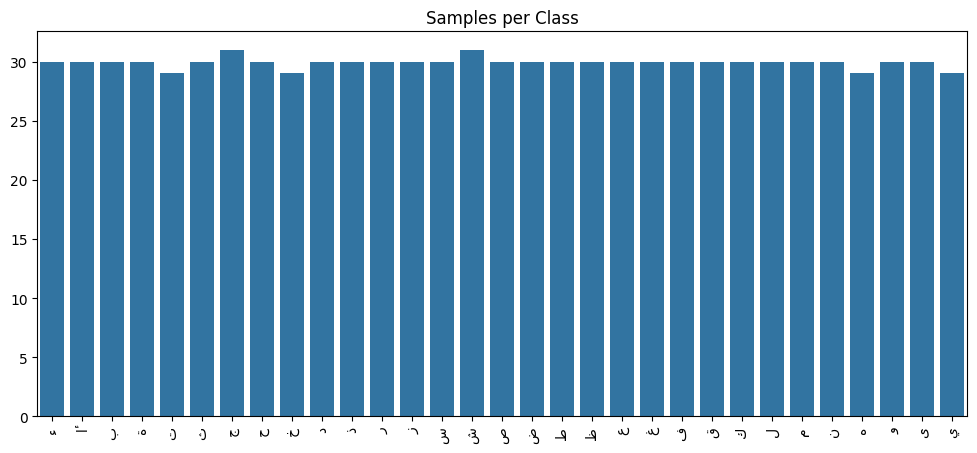

✅ EEGNet input shape: (928, 12, 1200, 1)
✅ After Augmentation: (3712, 12, 1200, 1), (3712, 31)


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 12, 1200, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 12, 1200, 24)   │         1,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 12, 1200, 24)   │            96 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ depthwise_conv2d_2              │ (None, 1, 1200, 48)    │           576 │
│ (DepthwiseConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 1, 1200, 48)    │           192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_10 (Activation)      │ (None, 1, 1200, 48)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_6             │ (None, 1, 300, 48)     │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 1, 300, 48)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 1, 300, 48)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_5              │ (None, 1, 300, 64)     │         3,456 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 1, 300, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_12 (Activation)      │ (None, 1, 300, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_8             │ (None, 1, 150, 64)     │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 1, 150, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 9600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │     1,228,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 31)             │         3,999 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,239,039 (4.73 MB)

 Trainable params: 1,238,767 (4.73 MB)

 Non-trainable params: 272 (1.06 KB)

Epoch 1/400
149/149 ━━━━━━━━━━━━━━━━━━━━ 16s 50ms/step - accuracy: 0.0603 - loss: 3.5239 - val_accuracy: 0.1566 - val_loss: 3.4847 - learning_rate: 1.0000e-04
Epoch 2/400
149/149 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.3808 - loss: 3.2282 - val_accuracy: 0.2340 - val_loss: 3.3547 - learning_rate: 1.0000e-04
Epoch 3/400
149/149 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.4672 - loss: 2.9670 - val_accuracy: 0.3030 - val_loss: 3.1446 - learning_rate: 1.0000e-04
Epoch 4/400
149/149 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.5091 - loss: 2.7938 - val_accuracy: 0.3384 - val_loss: 3.0029 - learning_rate: 1.0000e-04
Epoch 5/400
149/149 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.5135 - loss: 2.6294 - val_accuracy: 0.3704 - val_loss: 2.9096 - learning_rate: 1.0000e-04
Epoch 6/400
149/149 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.5695 - loss: 2.5176 - val_accuracy: 0.3889 - val_loss: 2.8503 - learning_rate: 1.0000e-04
Epoch 7/400
149/149 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/st

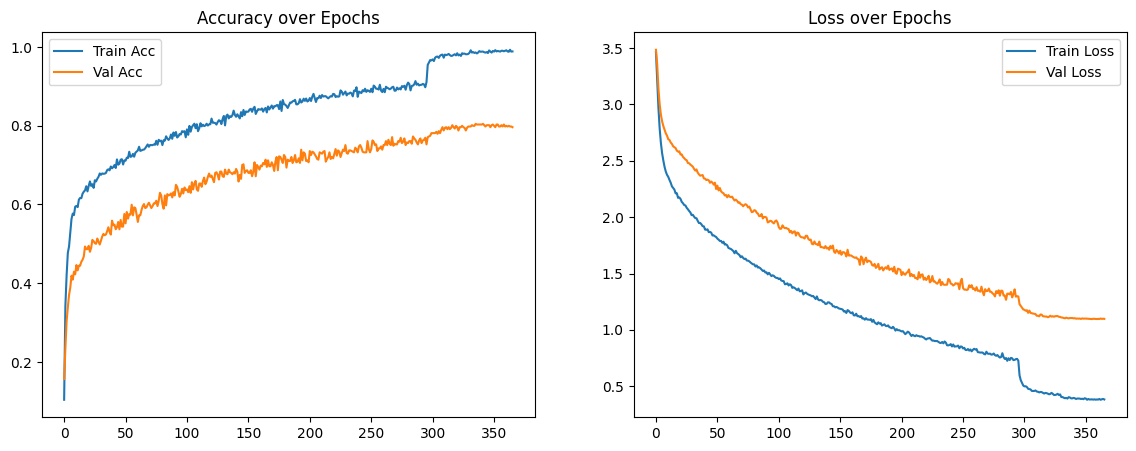


✅ Test Loss: 1.3454, Test Accuracy: 0.7456
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

✅ Test-Time Augmentation Accuracy: 0.7160


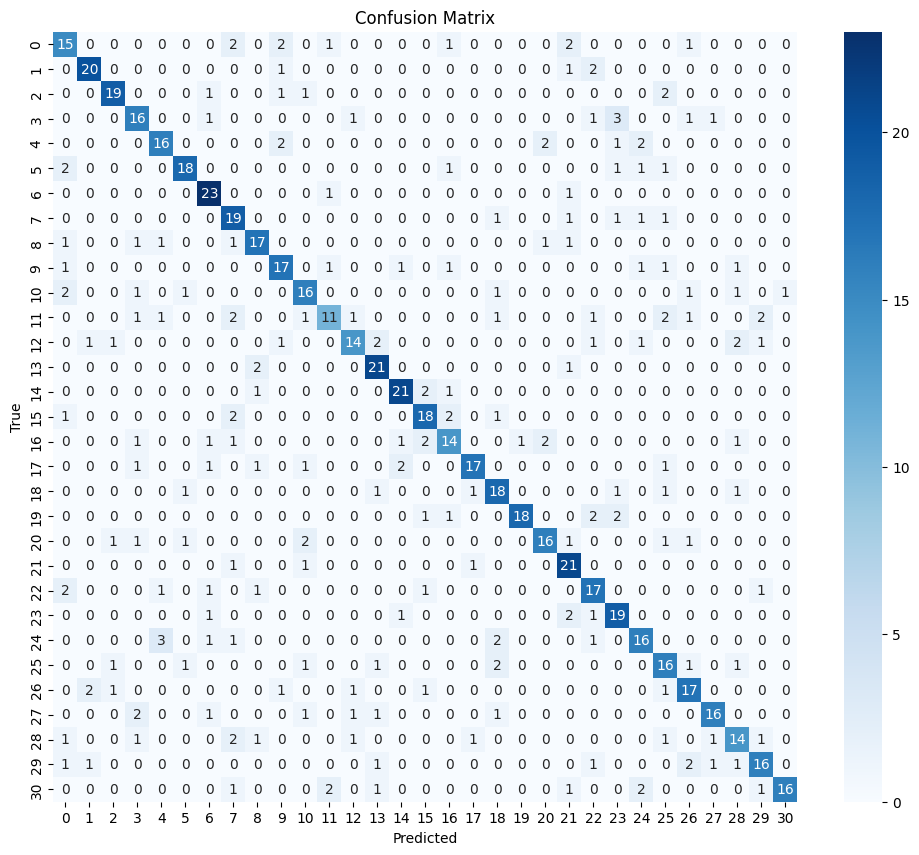


🔍 Classification Report:
              precision    recall  f1-score   support

           ء       0.58      0.62      0.60        24
          أ       0.83      0.83      0.83        24
           ب       0.83      0.79      0.81        24
           ة       0.64      0.67      0.65        24
           ت       0.73      0.70      0.71        23
           ث       0.82      0.75      0.78        24
           ج       0.74      0.92      0.82        25
           ح       0.59      0.79      0.68        24
           خ       0.74      0.74      0.74        23
           د       0.68      0.71      0.69        24
           ذ       0.67      0.67      0.67        24
           ر       0.69      0.46      0.55        24
           ز       0.74      0.58      0.65        24
           س       0.75      0.88      0.81        24
           ش       0.81      0.84      0.82        25
           ص       0.72      0.75      0.73        24
           ض       0.67      0.58      0.62        24
 

In [ ]:
# -------------------- 1. Imports --------------------
import numpy as np
import tensorflow as tf
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Conv2D, DepthwiseConv2D,
    SeparableConv2D, BatchNormalization, Activation, AveragePooling2D,
    Dropout, Flatten, Dense)
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
import pickle
import collections

# -------------------- 2. Data Augmentation Functions --------------------
def add_noise(signal, noise_level=0.05):
    noise = np.random.normal(0, noise_level, signal.shape)
    return signal + noise

def time_shift(signal, shift_max=50):
    shift = np.random.randint(-shift_max, shift_max)
    return np.roll(signal, shift, axis=0)

def scale_amplitude(signal, scale_range=(0.8, 1.2)):
    scale = np.random.uniform(scale_range[0], scale_range[1])
    return signal * scale

def augment_segment(segment):
    if random.random() < 0.7:
        segment = add_noise(segment, noise_level=random.uniform(0.01, 0.1))
    if random.random() < 0.7:
        segment = time_shift(segment, shift_max=random.randint(10, 50))
    if random.random() < 0.7:
        segment = scale_amplitude(segment, scale_range=(0.7, 1.3))
    return segment

# -------------------- 3. Prepare Dataset --------------------
X = []
y = []

for segment_array, label, participant in segmented_dataset:
    X.append(segment_array)
    y.append(label)

X = np.array(X)
y = np.array(y)

print(f"✅ Data Shape: {X.shape}, Labels Shape: {y.shape}")

counter = collections.Counter(y)
plt.figure(figsize=(12,5))
sns.barplot(x=list(counter.keys()), y=list(counter.values()))
plt.xticks(rotation=90)
plt.title("Samples per Class")
plt.show()

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_one_hot = to_categorical(y_encoded)

with open("label_encoder_final.pkl", "wb") as f:
    pickle.dump(label_encoder, f)

X = np.expand_dims(X, axis=-1)
X = np.transpose(X, (0, 2, 1, 3))
print(f"✅ EEGNet input shape: {X.shape}")

# -------------------- 4. Augment Dataset (Improved) --------------------
X_augmented = []
y_augmented = []

# Calculate class weights for balancing - we'll create more augmentations for minority classes
class_counts = collections.Counter(np.argmax(y_one_hot, axis=1))
max_count = max(class_counts.values())
class_multipliers = {cls: max(1, int(3.0 * max_count / count)) for cls, count in class_counts.items()}

for i in range(len(X)):
    # Add original sample
    X_augmented.append(X[i])
    y_augmented.append(y_one_hot[i])

    # Get class of this sample
    cls = np.argmax(y_one_hot[i])

    # Add more augmentations for minority classes
    num_augmentations = min(class_multipliers[cls], 5)  # Cap at 5 augmentations

    for _ in range(num_augmentations):
        augmented = augment_segment(X[i][:,:,0].T)
        augmented = np.expand_dims(augmented, axis=-1).transpose(1, 0, 2)
        X_augmented.append(augmented)
        y_augmented.append(y_one_hot[i])

X = np.array(X_augmented)
y = np.array(y_augmented)

print(f"✅ After Augmentation: {X.shape}, {y.shape}")

# -------------------- 5. Train-Test Split --------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=np.argmax(y, axis=1)
)

# -------------------- 6. Optimized EEGNet Model (Refined version of your original) --------------------
def Optimized_EEGNet(nb_classes, Chans=12, Samples=1200, dropoutRate=0.25, kernLength=64, F1=16, D=2, F2=32, norm_rate=0.25):
    """
    Optimized version of your Bigger_EEGNet with tuned hyperparameters,
    maintaining the same architecture but with better regularization
    """
    reg = tf.keras.regularizers.l2(1e-3)  # Increased regularization
    input1 = Input(shape=(Chans, Samples, 1))

    # First block
    block1 = Conv2D(F1, (1, kernLength), padding='same', use_bias=False, kernel_regularizer=reg)(input1)
    block1 = BatchNormalization()(block1)
    block1 = DepthwiseConv2D((Chans, 1), use_bias=False, depth_multiplier=D,
                             depthwise_constraint=tf.keras.constraints.max_norm(1.),
                             depthwise_regularizer=reg)(block1)
    block1 = BatchNormalization()(block1)
    block1 = Activation('elu')(block1)
    block1 = AveragePooling2D((1, 4))(block1)
    block1 = Dropout(dropoutRate)(block1)

    # Second block
    block2 = SeparableConv2D(F2, (1, 16), use_bias=False, padding='same',
                             depthwise_regularizer=reg, pointwise_regularizer=reg)(block1)
    block2 = BatchNormalization()(block2)
    block2 = Activation('elu')(block2)
    block2 = AveragePooling2D((1, 4))(block2)
    block2 = Dropout(dropoutRate)(block1)  # Add extra dropout for better regularization

    # Third block (same as your original)
    block3 = SeparableConv2D(64, (1, 8), use_bias=False, padding='same',
                             depthwise_regularizer=reg, pointwise_regularizer=reg)(block2)
    block3 = BatchNormalization()(block3)
    block3 = Activation('elu')(block3)
    block3 = AveragePooling2D((1, 2))(block3)
    block3 = Dropout(dropoutRate)(block3)

    flatten = Flatten()(block3)

    # Additional dense layer for more capacity
    dense1 = Dense(128, activation='elu', kernel_regularizer=reg,
                  kernel_constraint=tf.keras.constraints.max_norm(norm_rate))(flatten)
    dense1 = Dropout(dropoutRate)(dense1)  # Extra dropout

    dense = Dense(nb_classes, activation='softmax',
                 kernel_constraint=tf.keras.constraints.max_norm(norm_rate))(dense1)

    return Model(inputs=input1, outputs=dense)


model = Optimized_EEGNet(
    nb_classes=y_train.shape[1],
    Chans=X_train.shape[1],
    Samples=X_train.shape[2],
    dropoutRate=0.3,  # Slight adjustment to dropout for balance between regularization and capacity
    F1=24,  # Slightly increased filters for first layer
    F2=48,  # Slightly increased filters for second layer
)

# Initialize optimizer with lower learning rate for stability
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)  # Lower initial learning rate

model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
model.summary()

# -------------------- 7. Improved Callbacks --------------------
callbacks = [
    ModelCheckpoint('best_eegnet_model.keras', monitor='val_accuracy', save_best_only=True, mode='max'),
    EarlyStopping(monitor='val_accuracy', patience=30, restore_best_weights=True, mode='max'),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, min_lr=1e-6, verbose=1)
]

# -------------------- 8. Class Weights (Better balanced) --------------------
class_weights = dict(
    enumerate(compute_class_weight(
        class_weight='balanced',
        classes=np.unique(np.argmax(y_train, axis=1)),
        y=np.argmax(y_train, axis=1)
    ))
)

# Cap extreme class weights to avoid instability
max_weight = 10.0  # Maximum allowed class weight
class_weights = {cls: min(weight, max_weight) for cls, weight in class_weights.items()}

# -------------------- 9. Train the Model --------------------
history = model.fit(
    X_train, y_train,
    batch_size=16,  # Reduced batch size for better generalization
    epochs=400,  # Increased max epochs, early stopping will prevent overfitting
    validation_split=0.2,
    callbacks=callbacks,
    class_weight=class_weights,
    verbose=1
)

# 9.1. Save Final Trained Model
model.save('/content/drive/MyDrive/final_eegnet_model.keras')
print("✅ Final trained model saved as 'final_eegnet_model.keras'")

# 9.2. Save Label Encoder
with open("/content/drive/MyDrive/label_encoder_final.pkl", "wb") as f:
    pickle.dump(label_encoder, f)
print("✅ Label encoder saved as 'label_encoder_final.pkl'")


# -------------------- 10. Plot Training Curves --------------------
plt.figure(figsize=(14,5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy over Epochs')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss over Epochs')
plt.legend()

plt.show()

# -------------------- 11. Evaluate --------------------
# Load best model saved during training
best_model = tf.keras.models.load_model('best_eegnet_model.keras')

loss, accuracy = best_model.evaluate(X_test, y_test, verbose=0)
print(f"\n✅ Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}")

# -------------------- 12. Test Time Augmentation --------------------
# Create multiple slightly augmented versions of test samples and average predictions
def test_time_augmentation(model, X_test, n_augmentations=5):
    num_classes = model.output_shape[-1]
    all_predictions = np.zeros((X_test.shape[0], num_classes))

    # Predict original test set
    all_predictions += model.predict(X_test)

    for i in range(n_augmentations):
        X_test_aug = []
        for x in X_test:
            signal = x[:, :, 0]  # shape: (12, 1200)
            augmented = augment_segment(signal)  # should return same shape
            augmented = np.expand_dims(augmented, axis=-1)  # shape: (12, 1200, 1)
            X_test_aug.append(augmented)

        X_test_aug = np.array(X_test_aug)
        all_predictions += model.predict(X_test_aug)

    return all_predictions / (n_augmentations + 1)


    # Average predictions
    return all_predictions / (n_augmentations + 1)

# Use test-time augmentation for final predictions
y_pred_probs = test_time_augmentation(best_model, X_test, n_augmentations=10)
y_pred_labels = np.argmax(y_pred_probs, axis=-1)
y_true_labels = np.argmax(y_test, axis=-1)

# Calculate TTA accuracy
tta_accuracy = np.mean(y_pred_labels == y_true_labels)
print(f"\n✅ Test-Time Augmentation Accuracy: {tta_accuracy:.4f}")

# -------------------- 13. Confusion Matrix --------------------
cm = confusion_matrix(y_true_labels, y_pred_labels)
plt.figure(figsize=(12,10))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# -------------------- 14. Classification Report --------------------
report = classification_report(y_true_labels, y_pred_labels, target_names=label_encoder.classes_)
print("\n🔍 Classification Report:")
print(report)

# -------------------- 15. Example Predictions --------------------
print("\n🔍 Example Predictions:")
for i in range(5):
    true_label = label_encoder.inverse_transform([y_true_labels[i]])[0]
    predicted_label = label_encoder.inverse_transform([y_pred_labels[i]])[0]
    confidence = np.max(y_pred_probs[i])
    print(f"True: {true_label}, Predicted: {predicted_label}, Confidence: {confidence:.4f}")